In [3]:
import os
import math
import pandas as pd
import TimeSeriesForecasters
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import regularizers

In [4]:
def wape(y_true, y_pred):
    # Prevent from dividing by 0 like in MAPE
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
targets = ["Tiny+Small_+1", "Large+Mature_+1", "Tiny+Small_+2", "Large+Mature_+2", "Tiny+Small_+3", "Large+Mature_+3",
"Tiny+Small_+4", "Large+Mature_+4", "Tiny+Small_+5", "Large+Mature_+5", "Tiny+Small_+6", "Large+Mature_+6"]

In [7]:
data = pd.read_csv("../Data/prepared_data.csv")

In [8]:
data

FarmID  year  month  Tiny+Small  Large+Mature  temperature_2m_max  \
0      AG10  1998      1        43.0          13.0           34.741935   
1      AG10  1998      2        28.0          28.0           35.189286   
2      AG10  1998      3        13.0          43.0           35.725806   
3      AG10  1998      4        11.5          38.0           33.100000   
4      AG10  1998      5        10.0          33.0           32.254839   
...     ...   ...    ...         ...           ...                 ...   
9011  MA413  2023      3         2.0          11.0           32.625806   
9012  MA413  2023      4         2.0           3.0           32.833333   
9013  MA413  2023      5         3.0           4.0           32.225806   
9014  MA413  2023      6         1.0           1.0           29.463333   
9015  MA413  2023      7         2.0           2.0           28.550000   

      temperature_2m_min  apparent_temperature_max  apparent_temperature_min  \
0              22.393548                 36.770968                 25.441935   
1              24.317857                 39.117857                 28.378571   
2              25.367742                 40.496774                 29.983871   
3              24.903333                 39.120000                 29.943333   
4              24.303226                 37.919355                 29.096774   
...                  ...                       ...                       ...   
9011           23.593548                 37.380645                 27.251613   
9012           23.786667                 37.903333                 27.520000   
9013           24.061290                 37.435484                 28.312903   
9014           22.926667                 33.333333                 26.320000   
9015           22.850000                 32.500000                 25.900000   

      precipitation_sum  ...  shortwave_radiation_sum  \
0              0.429032  ...                20.136774   
1              1.857143  ...                20.272143   
2              1.654839  ...                20.438065   
3              4.073333  ...                17.877667   
4              2.603226  ...                17.486452   
...                 ...  ...                      ...   
9011           2.758065  ...                19.784194   
9012           2.563333  ...                20.378667   
9013           3.029032  ...                18.983226   
9014           6.823333  ...                14.725667   
9015           9.050000  ...                14.565000   

      et0_fao_evapotranspiration  soil_temperature_0_to_7cm  \
0                       4.689677                  29.146371   
1                       4.714643                  30.208780   
2                       4.916774                  31.365054   
3                       4.014333                  29.077639   
4                       3.876129                  28.380780   
...                          ...                        ...   
9011                    4.540323                  28.529167   
9012                    4.632667                  28.858889   
9013                    4.261290                  28.559140   
9014                    3.271000                  26.370000   
9015                    3.130000                  25.981250   

      soil_temperature_7_to_28cm  soil_temperature_28_to_100cm  \
0                      28.788575                     27.784005   
1                      29.864286                     28.965923   
2                      31.121774                     30.227554   
3                      29.184167                     29.357361   
4                      28.423656                     28.578495   
...                          ...                           ...   
9011                   28.526478                     28.419355   
9012                   28.759306                     28.444028   
9013                   28.523656                     28.383737   
9014                   26.618611                     

In [9]:
data.columns

Index(['FarmID', 'year', 'month', 'Tiny+Small', 'Large+Mature',
       'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'precipitation_sum', 'rain_sum',
       'precipitation_hours', 'windspeed_10m_max', 'windgusts_10m_max',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm'],
      dtype='object')

In [10]:
data_FE_FS = pd.read_csv("../Data/prepared_data_FE_FS.csv")
data_FE_FS = data_FE_FS.iloc[:, 1:].drop(columns=targets)

In [11]:
data_FE_FS

FarmID  year  month  Tiny+Small  Large+Mature  apparent_temperature_max  \
0      AG10  1999      1         8.0           5.0                 35.741935   
1      AG10  1999      2         6.5          11.0                 36.375000   
2      AG10  1999      3         5.0          17.0                 37.390323   
3      AG10  1999      4        18.0          14.0                 37.423333   
4      AG10  1999      5        31.0          11.0                 36.832258   
...     ...   ...    ...         ...           ...                       ...   
8591  MA413  2022      9         4.0          45.0                 32.260000   
8592  MA413  2022     10         2.0          37.0                 34.119355   
8593  MA413  2022     11         5.0          17.0                 34.520000   
8594  MA413  2022     12        15.0          10.0                 34.325806   
8595  MA413  2023      1         6.0          11.0                 35.596774   

      rain_sum  precipitation_hours  windgusts_10m_max  \
0     0.890323             2.741935          24.187097   
1     2.792857             3.571429          25.178571   
2     2.367742             3.645161          29.335484   
3     3.800000             3.433333          29.006667   
4     2.822581             4.193548          27.741935   
...        ...                  ...                ...   
8591  7.030000            13.200000          26.163333   
8592  4.745161             9.290323          25.064516   
8593  1.643333             4.833333          25.740000   
8594  0.596774             1.516129          24.935484   
8595  0.696774             0.903226          25.000000   

      soil_moisture_28_to_100cm  ...  lag_windgusts_10m_max_6  \
0                      0.375906  ...                29.403226   
1                      0.351524  ...                29.493548   
2                      0.346919  ...                26.860000   
3                      0.337085  ...                25.229032   
4                      0.333712  ...                26.223333   
...                         ...  ...                      ...   
8591                   0.493833  ...                27.680645   
8592                   0.489003  ...                27.836667   
8593                   0.430129  ...                23.700000   
8594                   0.381405  ...                26.046667   
8595                   0.339251  ...                25.293548   

      lag_windgusts_10m_max_7  lag_windgusts_10m_max_8  \
0                   26.640000                28.103226   
1                   29.403226                26.640000   
2                   29.493548                29.403226   
3                   26.860000                29.493548   
4                   25.229032                26.860000   
...                       ...                      ...   
8591                28.478571                25.693548   
8592                27.680645                28.478571   
8593                27.836667                27.680645   
8594                23.700000                27.836667   
8595                26.046667                23.700000   

      lag_shortwave_radiation_sum_6  lag_shortwave_radiation_sum_7  \
0                         13.650645                      16.397333   
1                         12.649677                      13.650645   
2                         14.029000                      12.649677   
3                         16.064194                      14.029000   
4                         14.828667                      16.064194   
...                             ...                            ...   
8591                      19.948065                      20.812857   
8592                      19.645000                      19.948065   
8593                      17.290323                      19.645000   
8594                      17.048667                      17.290323   
8595                      13.522258                      17.048667   

      lag_soil_temperature_1

In [12]:
def make_date_index(df):
    df["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in df.iterrows()]
    df["Date"] = pd.to_datetime(df["Date"])
    df.index = df["Date"]
    df.drop(columns=["Date"], inplace=True)

## Baseline (Naive method)

In [13]:
n_lags = 12

data_lags = data.copy()


for column in ["Tiny+Small", "Large+Mature"]:
    for i in range(1, n_lags+1):
        data_lags['lag_' + str(column) + '_' + str(i)] = data_lags.groupby("FarmID")[column].shift(i)


# Step 2: Drop rows with NaN values
data_lags.dropna(inplace=True)

In [14]:
data_lags

FarmID  year  month  Tiny+Small  Large+Mature  temperature_2m_max  \
12     AG10  1999      1         8.0           5.0           31.564516   
13     AG10  1999      2         6.5          11.0           32.542857   
14     AG10  1999      3         5.0          17.0           32.154839   
15     AG10  1999      4        18.0          14.0           31.793333   
16     AG10  1999      5        31.0          11.0           31.480645   
...     ...   ...    ...         ...           ...                 ...   
9011  MA413  2023      3         2.0          11.0           32.625806   
9012  MA413  2023      4         2.0           3.0           32.833333   
9013  MA413  2023      5         3.0           4.0           32.225806   
9014  MA413  2023      6         1.0           1.0           29.463333   
9015  MA413  2023      7         2.0           2.0           28.550000   

      temperature_2m_min  apparent_temperature_max  apparent_temperature_min  \
12             23.000000                 35.741935                 27.183871   
13             22.714286                 36.375000                 26.371429   
14             23.590323                 37.390323                 27.803226   
15             23.596667                 37.423333                 27.980000   
16             23.425806                 36.832258                 27.774194   
...                  ...                       ...                       ...   
9011           23.593548                 37.380645                 27.251613   
9012           23.786667                 37.903333                 27.520000   
9013           24.061290                 37.435484                 28.312903   
9014           22.926667                 33.333333                 26.320000   
9015           22.850000                 32.500000                 25.900000   

      precipitation_sum  ...  lag_Large+Mature_3  lag_Large+Mature_4  \
12             0.890323  ...               101.0               167.0   
13             2.792857  ...                59.0               101.0   
14             2.367742  ...                17.0                59.0   
15             3.800000  ...                 5.0                17.0   
16             2.822581  ...                11.0                 5.0   
...                 ...  ...                 ...                 ...   
9011           2.758065  ...                10.0                17.0   
9012           2.563333  ...                11.0                10.0   
9013           3.029032  ...                11.0                11.0   
9014           6.823333  ...                11.0                11.0   
9015           9.050000  ...                 3.0                11.0   

      lag_Large+Mature_5  lag_Large+Mature_6  lag_Large+Mature_7  \
12                  62.0                39.5                17.0   
13                 167.0                62.0                39.5   
14                 101.0               167.0                62.0   
15                  59.0               101.0               167.0   
16                  17.0                59.0               101.0   
...                  ...                 ...                 ...   
9011                37.0                45.0                36.0   
9012                17.0                37.0                45.0   
9013                10.0                17.0                37.0   
9014                11.0                10.0                17.0   
9015                11.0                11.0                10.0   

      lag_Large+Mature_8  lag_Large+Mature_9  lag_Large+Mature_10  \
12                  33.0                38.0                 43.0   
13                  17.0                33.0                 38.0   
14                  39.5                17.0                 33.0   
15                  62.0                39.5                 17.0   
16                 167.0                62.0                 39.5   
...                  ...                 ...               

In [15]:
targets = ["Tiny+Small", "Large+Mature"]
processed_targets = []
steps_ahead = 6
for target in targets:
    for i in range(1, steps_ahead+1):
        data_lags[f"{target}_+{i}"] = data_lags.groupby("FarmID")[target].shift(-i)
        processed_targets.append(f"{target}_+{i}")

data_lags = data_lags.dropna()

In [16]:
for column in data_lags.columns:
    print(column)

FarmID
year
month
Tiny+Small
Large+Mature
temperature_2m_max
temperature_2m_min
apparent_temperature_max
apparent_temperature_min
precipitation_sum
rain_sum
precipitation_hours
windspeed_10m_max
windgusts_10m_max
shortwave_radiation_sum
et0_fao_evapotranspiration
soil_temperature_0_to_7cm
soil_temperature_7_to_28cm
soil_temperature_28_to_100cm
soil_temperature_100_to_255cm
soil_moisture_0_to_7cm
soil_moisture_7_to_28cm
soil_moisture_28_to_100cm
soil_moisture_100_to_255cm
lag_Tiny+Small_1
lag_Tiny+Small_2
lag_Tiny+Small_3
lag_Tiny+Small_4
lag_Tiny+Small_5
lag_Tiny+Small_6
lag_Tiny+Small_7
lag_Tiny+Small_8
lag_Tiny+Small_9
lag_Tiny+Small_10
lag_Tiny+Small_11
lag_Tiny+Small_12
lag_Large+Mature_1
lag_Large+Mature_2
lag_Large+Mature_3
lag_Large+Mature_4
lag_Large+Mature_5
lag_Large+Mature_6
lag_Large+Mature_7
lag_Large+Mature_8
lag_Large+Mature_9
lag_Large+Mature_10
lag_Large+Mature_11
lag_Large+Mature_12
Tiny+Small_+1
Tiny+Small_+2
Tiny+Small_+3
Tiny+Small_+4
Tiny+Small_+5
Tiny+Small_+6
La

In [17]:
tbl_scores = {"FarmID": [], "Target": [], "rmse": [], "wape": [], "r2": [], "mae": []}
targets = {"Tiny+Small_+1": "lag_Tiny+Small_11", "Tiny+Small_+2": "lag_Tiny+Small_10", "Tiny+Small_+3": "lag_Tiny+Small_9", "Tiny+Small_+4": "lag_Tiny+Small_8", 
           "Tiny+Small_+5": "lag_Tiny+Small_7", "Tiny+Small_+6": "lag_Tiny+Small_6", "Large+Mature_+1": "lag_Large+Mature_11", "Large+Mature_+2": "lag_Large+Mature_10", 
           "Large+Mature_+3": "lag_Large+Mature_9", "Large+Mature_+4": "lag_Large+Mature_8", "Large+Mature_+5": "lag_Large+Mature_7", "Large+Mature_+6": "lag_Large+Mature_6"}
for farmid in data_lags["FarmID"].unique():
    for target in targets.keys():
        preds = data_lags[data_lags["FarmID"] == farmid][targets[target]]
        real = data_lags[data_lags["FarmID"] == farmid][target]
        tbl_scores["FarmID"].append(farmid)
        tbl_scores["Target"].append(target)
        tbl_scores["rmse"].append(sqrt(mse(real, preds)))
        tbl_scores["wape"].append(wape(real, preds))
        tbl_scores["r2"].append(r2_score(real, preds))
        tbl_scores["mae"].append(mae(real, preds))

In [18]:
tbl_scores = pd.DataFrame(tbl_scores)

In [19]:
tbl_scores

FarmID           Target       rmse      wape        r2        mae
0     AG10    Tiny+Small_+1  46.754932  0.774673 -0.235813  30.795271
1     AG10    Tiny+Small_+2  46.741526  0.773773 -0.234858  30.755479
2     AG10    Tiny+Small_+3  46.739305  0.771304 -0.237590  30.734717
3     AG10    Tiny+Small_+4  46.738333  0.769150 -0.238580  30.726067
4     AG10    Tiny+Small_+5  46.781216  0.769396 -0.240699  30.791811
..     ...              ...        ...       ...       ...        ...
811  MA413  Large+Mature_+2  18.506168  0.609943 -0.626325  13.869565
812  MA413  Large+Mature_+3  18.794657  0.631528 -0.622713  14.195652
813  MA413  Large+Mature_+4  18.907670  0.663022 -0.604826  14.500000
814  MA413  Large+Mature_+5  18.935244  0.703239 -0.676248  14.630435
815  MA413  Large+Mature_+6  18.981112  0.746417 -0.808228  14.717391

[816 rows x 6 columns]

In [20]:
for target in tbl_scores["Target"].unique():
    target_mean = tbl_scores[tbl_scores["Target"] == target]["rmse"].mean()
    print(f"{target} -> {target_mean}")

Tiny+Small_+1 -> 36.00894953737098
Tiny+Small_+2 -> 35.84191045848665
Tiny+Small_+3 -> 35.73392990671551
Tiny+Small_+4 -> 35.71157863490337
Tiny+Small_+5 -> 35.939524111780884
Tiny+Small_+6 -> 35.8570292043899
Large+Mature_+1 -> 29.99665042958386
Large+Mature_+2 -> 29.81387852728626
Large+Mature_+3 -> 29.677671003142276
Large+Mature_+4 -> 29.54163176847517
Large+Mature_+5 -> 29.501272887025987
Large+Mature_+6 -> 29.679321877683027


In [21]:
data_lags["Date"] = [datetime(int(row["year"]), int(row["month"]), 1) for index, row in data_lags.iterrows()]
data_lags["Date"] = pd.to_datetime(data_lags["Date"])
data_lags.index = data_lags["Date"]
data_lags.drop(columns=["Date"], inplace=True)

In [22]:
scaler = MinMaxScaler()
temp_df = pd.DataFrame(scaler.fit_transform(data_lags[data_lags["FarmID"] == "DA41"][["lag_Large+Mature_6", "Large+Mature_+6"]]))
temp_df = temp_df.rename(columns={0: "Prediction", 1: "Real"})
temp_df.index = data_lags[data_lags["FarmID"] == "DA41"][["lag_Large+Mature_6", "Large+Mature_+6"]].index

<Axes: title={'center': 'Przebieg predykcji oraz rzeczywistych wartości (metoda naiwna) dla t+n, gdzie n = 6'}, xlabel='Data', ylabel='Znormalizowana wartość zbioru'>

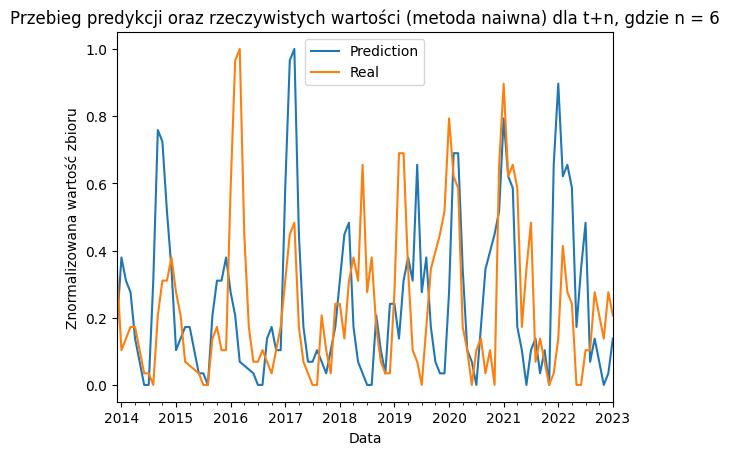

In [23]:
temp_df.plot(xlabel="Data", ylabel="Znormalizowana wartość zbioru", title="Przebieg predykcji oraz rzeczywistych wartości (metoda naiwna) dla t+n, gdzie n = 6")

In [25]:
data_lags[data_lags["FarmID"] == "DA41"][["lag_Large+Mature_6", "Large+Mature_+6"]]

lag_Large+Mature_6  Large+Mature_+6
Date                                           
2013-12-01                 5.0             10.0
2014-01-01                11.0              3.0
2014-02-01                 9.0              4.0
2014-03-01                 8.0              5.0
2014-04-01                 4.0              5.0
...                        ...              ...
2022-09-01                 4.0              8.0
2022-10-01                 2.0              6.0
2022-11-01                 0.0              4.0
2022-12-01                 1.0              8.0
2023-01-01                 4.0              6.0

[110 rows x 2 columns]

In [30]:
data_lags.drop(columns=['Tiny+Small', 'Large+Mature',
       'temperature_2m_max', 'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'precipitation_sum', 'rain_sum',
       'precipitation_hours', 'windspeed_10m_max', 'windgusts_10m_max',
       'shortwave_radiation_sum', 'et0_fao_evapotranspiration',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'soil_moisture_100_to_255cm']).to_csv("./Results/base/preds.csv")

In [ ]:
tbl_scores.to_csv("./Results/base/base_scores.csv")

## Tree-based models

### RandomForest

#### Raw data

In [ ]:
data

FarmID  year  month  Tiny+Small  Large+Mature  temperature_2m_max  \
0      AG10  1998      1        43.0          13.0           34.741935   
1      AG10  1998      2        28.0          28.0           35.189286   
2      AG10  1998      3        13.0          43.0           35.725806   
3      AG10  1998      4        11.5          38.0           33.100000   
4      AG10  1998      5        10.0          33.0           32.254839   
...     ...   ...    ...         ...           ...                 ...   
9011  MA413  2023      3         2.0          11.0           32.625806   
9012  MA413  2023      4         2.0           3.0           32.833333   
9013  MA413  2023      5         3.0           4.0           32.225806   
9014  MA413  2023      6         1.0           1.0           29.463333   
9015  MA413  2023      7         2.0           2.0           28.550000   

      temperature_2m_min  apparent_temperature_max  apparent_temperature_min  \
0              22.393548                 36.770968                 25.441935   
1              24.317857                 39.117857                 28.378571   
2              25.367742                 40.496774                 29.983871   
3              24.903333                 39.120000                 29.943333   
4              24.303226                 37.919355                 29.096774   
...                  ...                       ...                       ...   
9011           23.593548                 37.380645                 27.251613   
9012           23.786667                 37.903333                 27.520000   
9013           24.061290                 37.435484                 28.312903   
9014           22.926667                 33.333333                 26.320000   
9015           22.850000                 32.500000                 25.900000   

      precipitation_sum  ...  shortwave_radiation_sum  \
0              0.429032  ...                20.136774   
1              1.857143  ...                20.272143   
2              1.654839  ...                20.438065   
3              4.073333  ...                17.877667   
4              2.603226  ...                17.486452   
...                 ...  ...                      ...   
9011           2.758065  ...                19.784194   
9012           2.563333  ...                20.378667   
9013           3.029032  ...                18.983226   
9014           6.823333  ...                14.725667   
9015           9.050000  ...                14.565000   

      et0_fao_evapotranspiration  soil_temperature_0_to_7cm  \
0                       4.689677                  29.146371   
1                       4.714643                  30.208780   
2                       4.916774                  31.365054   
3                       4.014333                  29.077639   
4                       3.876129                  28.380780   
...                          ...                        ...   
9011                    4.540323                  28.529167   
9012                    4.632667                  28.858889   
9013                    4.261290                  28.559140   
9014                    3.271000                  26.370000   
9015                    3.130000                  25.981250   

      soil_temperature_7_to_28cm  soil_temperature_28_to_100cm  \
0                      28.788575                     27.784005   
1                      29.864286                     28.965923   
2                      31.121774                     30.227554   
3                      29.184167                     29.357361   
4                      28.423656                     28.578495   
...                          ...                           ...   
9011                   28.526478                     28.419355   
9012                   28.759306                     28.444028   
9013                   28.523656                     28.383737   
9014                   26.618611                     

In [ ]:
model = RandomForestRegressor()
randTreesTimeSeriesForecaster = TimeSeriesForecasters.RegressionTimeSeriesForecaster(model)
forest_model, forest_preds, forest_scores = randTreesTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6).evaluate_model(5, "data_raw_RandomForest", "/Results/data_raw_RF")

In [ ]:
forest_preds

Model  Iter_n FarmID  year  month  \
0     data_raw_RandomForest_no_optim       1   AG10  2002      4   
1     data_raw_RandomForest_no_optim       1   AG10  2002      5   
2     data_raw_RandomForest_no_optim       1   AG10  2002      6   
3     data_raw_RandomForest_no_optim       1   AG10  2002      7   
4     data_raw_RandomForest_no_optim       1   AG10  2002      8   
...                              ...     ...    ...   ...    ...   
1401  data_raw_RandomForest_no_optim       5  MA413  2022      9   
1402  data_raw_RandomForest_no_optim       5  MA413  2022     10   
1403  data_raw_RandomForest_no_optim       5  MA413  2022     11   
1404  data_raw_RandomForest_no_optim       5  MA413  2022     12   
1405  data_raw_RandomForest_no_optim       5  MA413  2023      1   

      Tiny+Small_+1  Tiny+Small_+2  Tiny+Small_+3  Tiny+Small_+4  \
0              26.0          106.0          143.0          143.0   
1             106.0          143.0          143.0          134.3   
2             143.0          143.0          134.3          125.6   
3             143.0          134.3          125.6          116.9   
4             134.3          125.6          116.9          108.2   
...             ...            ...            ...            ...   
1401            2.0            5.0           15.0            6.0   
1402            5.0           15.0            6.0            1.0   
1403           15.0            6.0            1.0            2.0   
1404            6.0            1.0            2.0            2.0   
1405            1.0            2.0            2.0            3.0   

      Tiny+Small_+5  ...  Tiny+Small_+3_pred  Tiny+Small_+4_pred  \
0             134.3  ...          106.228333          100.170000   
1             125.6  ...           79.820000           51.285000   
2             116.9  ...           32.782000           23.382333   
3             108.2  ...           26.421667           26.493333   
4              99.5  ...           21.836667           24.453333   
...             ...  ...                 ...                 ...   
1401            1.0  ...           20.718500           24.782750   
1402            2.0  ...           20.551250           22.237500   
1403            2.0  ...           15.972500           17.555000   
1404            3.0  ...           16.347500           20.100000   
1405            1.0  ...           26.405000           50.980000   

      Tiny+Small_+5_pred  Tiny+Small_+6_pred  Large+Mature_+1_pred  \
0              59.516667           34.496667             17.672333   
1              30.731667           23.566778             16.642778   
2              24.324333           18.741333             50.485000   
3              30.886667           29.468333             85.640000   
4              25.740000           25.790000            138.095000   
...                  ...                 ...                   ...   
1401           20.787000           16.666250             33.005000   
1402           18.143750           23.445000             26.216667   
1403           27.297500           33.310000             12.548333   
1404           28.412500           35.780000             16.054167   
1405           54.120000           40.810000             10.880000   

      Large+Mature_+2_pred  Large+Mature_+3_pred  Large+Mature_+4_pred  \
0                17.323667             26.633333             62.581667   
1                28.140556             58.753333             94.271667   
2                70.010000             62.928000             42.376000   
3               104.413333             82.281667             48.403333   
4               102.771667             65.776667             34.663333   
...                    ...                   ...                   ...   
1401             22.221500             17.743000             20.379500   
1402             15.292500             13.411667             19.755833   
1403             10.928750             14.282500             17.356250   

In [ ]:
forest_scores

Model  Iter_n FarmID           Target  \
0     data_raw_RandomForest_no_optim       1   AG10    Tiny+Small_+1   
1     data_raw_RandomForest_no_optim       1   AG10    Tiny+Small_+2   
2     data_raw_RandomForest_no_optim       1   AG10    Tiny+Small_+3   
3     data_raw_RandomForest_no_optim       1   AG10    Tiny+Small_+4   
4     data_raw_RandomForest_no_optim       1   AG10    Tiny+Small_+5   
...                              ...     ...    ...              ...   
4075  data_raw_RandomForest_no_optim       5  MA413  Large+Mature_+2   
4076  data_raw_RandomForest_no_optim       5  MA413  Large+Mature_+3   
4077  data_raw_RandomForest_no_optim       5  MA413  Large+Mature_+4   
4078  data_raw_RandomForest_no_optim       5  MA413  Large+Mature_+5   
4079  data_raw_RandomForest_no_optim       5  MA413  Large+Mature_+6   

           rmse     wmape         r2        mae  
0     36.939431  0.459058   0.428516  25.271118  
1     49.633489  0.583728   0.092245  34.025481  
2     51.179996  0.583584   0.072785  34.495644  
3     49.498088  0.593914   0.097043  33.609601  
4     49.908613  0.633720   0.043434  34.151163  
...         ...       ...        ...        ...  
4075   6.244718  0.225534   0.772394   4.811398  
4076   6.703777  0.285106   0.776648   5.733806  
4077  13.610474  0.708584   0.021721  11.731009  
4078  18.774555  1.497085  -2.440732  17.465991  
4079  23.267286  2.898173 -19.510148  22.541343  

[4080 rows x 8 columns]

#### Features after selection

In [26]:
model = RandomForestRegressor()
randTreesTimeSeriesForecaster = TimeSeriesForecasters.RegressionTimeSeriesForecaster(model)
forest_model, forest_preds, forest_scores = randTreesTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6).evaluate_model(5, "data_FE_FS_RandomForest", "/Results/data_FE_FS_RF")

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5


In [27]:
forest_scores

Model  Iter_n FarmID           Target  \
0     data_FE_FS_RandomForest_no_optim       1   AG10    Tiny+Small_+1   
1     data_FE_FS_RandomForest_no_optim       1   AG10    Tiny+Small_+2   
2     data_FE_FS_RandomForest_no_optim       1   AG10    Tiny+Small_+3   
3     data_FE_FS_RandomForest_no_optim       1   AG10    Tiny+Small_+4   
4     data_FE_FS_RandomForest_no_optim       1   AG10    Tiny+Small_+5   
...                                ...     ...    ...              ...   
4075  data_FE_FS_RandomForest_no_optim       5  MA413  Large+Mature_+2   
4076  data_FE_FS_RandomForest_no_optim       5  MA413  Large+Mature_+3   
4077  data_FE_FS_RandomForest_no_optim       5  MA413  Large+Mature_+4   
4078  data_FE_FS_RandomForest_no_optim       5  MA413  Large+Mature_+5   
4079  data_FE_FS_RandomForest_no_optim       5  MA413  Large+Mature_+6   

           rmse     wmape        r2        mae  
0     33.565639  0.502740  0.523470  22.628666  
1     45.937969  0.768673  0.102784  33.178884  
2     46.210958  0.825310  0.092111  34.225801  
3     45.381653  0.850290  0.128400  33.951884  
4     44.339419  0.861192  0.172959  33.256674  
...         ...       ...       ...        ...  
4075   7.752792  0.281034  0.580001   6.428658  
4076   7.356850  0.252564  0.613017   6.598231  
4077   9.485656  0.301921  0.395870   7.623504  
4078  10.813439  0.359308  0.324528   8.309007  
4079  14.170671  0.563391 -0.071333  12.535457  

[4080 rows x 8 columns]

### XGBoost

In [21]:
import xgboost as xgb

#### Raw data

In [ ]:
xgBoostTimeSeriesForecaster = TimeSeriesForecasters.RegressionTimeSeriesForecaster(xgb.XGBRegressor())
xgb_model, xgb_preds, xgb_scores = xgBoostTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6).evaluate_model(5, "data_raw_XGBoost", "/Results/data_raw_XGBoost")

In [ ]:
xgb_scores

Model  Iter_n FarmID           Target       rmse  \
0     data_raw_XGBoost_no_optim       1   AG10    Tiny+Small_+1  35.489238   
1     data_raw_XGBoost_no_optim       1   AG10    Tiny+Small_+2  51.280684   
2     data_raw_XGBoost_no_optim       1   AG10    Tiny+Small_+3  53.385759   
3     data_raw_XGBoost_no_optim       1   AG10    Tiny+Small_+4  54.238932   
4     data_raw_XGBoost_no_optim       1   AG10    Tiny+Small_+5  52.027943   
...                         ...     ...    ...              ...        ...   
4075  data_raw_XGBoost_no_optim       5  MA413  Large+Mature_+2   5.695514   
4076  data_raw_XGBoost_no_optim       5  MA413  Large+Mature_+3   9.904023   
4077  data_raw_XGBoost_no_optim       5  MA413  Large+Mature_+4  11.855798   
4078  data_raw_XGBoost_no_optim       5  MA413  Large+Mature_+5  16.935783   
4079  data_raw_XGBoost_no_optim       5  MA413  Large+Mature_+6  14.114549   

         wmape        r2        mae  
0     0.442604  0.472506  24.365355  
1     0.597610  0.030993  34.834662  
2     0.610443 -0.008860  36.083257  
3     0.657562 -0.084208  37.211456  
4     0.700903 -0.039530  37.771667  
...        ...       ...        ...  
4075  0.196897  0.810668   4.200462  
4076  0.435314  0.512501   8.754656  
4077  0.560357  0.257703   9.277019  
4078  1.369622 -1.799769  15.978918  
4079  1.570445 -6.547643  12.214571  

[4080 rows x 8 columns]

#### Feature selection

In [22]:
xgBoostTimeSeriesForecaster = TimeSeriesForecasters.RegressionTimeSeriesForecaster(xgb.XGBRegressor())
xgb_model, xgb_preds, xgb_scores = xgBoostTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6).evaluate_model(5, "data_FE_FS_XGBoost", "/Results/data_FE_FS_XGBoost")

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5


In [23]:
xgb_scores

Model  Iter_n FarmID           Target       rmse  \
0     data_FE_FS_XGBoost_no_optim       1   AG10    Tiny+Small_+1  31.043363   
1     data_FE_FS_XGBoost_no_optim       1   AG10    Tiny+Small_+2  74.522612   
2     data_FE_FS_XGBoost_no_optim       1   AG10    Tiny+Small_+3  60.207601   
3     data_FE_FS_XGBoost_no_optim       1   AG10    Tiny+Small_+4  83.942503   
4     data_FE_FS_XGBoost_no_optim       1   AG10    Tiny+Small_+5  64.941417   
...                           ...     ...    ...              ...        ...   
4075  data_FE_FS_XGBoost_no_optim       5  MA413  Large+Mature_+2   9.766600   
4076  data_FE_FS_XGBoost_no_optim       5  MA413  Large+Mature_+3  14.083019   
4077  data_FE_FS_XGBoost_no_optim       5  MA413  Large+Mature_+4  16.455543   
4078  data_FE_FS_XGBoost_no_optim       5  MA413  Large+Mature_+5   9.515869   
4079  data_FE_FS_XGBoost_no_optim       5  MA413  Large+Mature_+6  17.517943   

         wmape        r2        mae  
0     0.424124  0.592397  19.090091  
1     1.123893 -1.361183  48.511539  
2     1.060728 -0.541152  43.988597  
3     1.687336 -1.982086  67.374952  
4     1.367269 -0.774151  52.799855  
...        ...       ...        ...  
4075  0.347176  0.333471   7.941648  
4076  0.380329 -0.418077   9.936090  
4077  0.524867 -0.818111  13.252887  
4078  0.303553  0.476910   7.019662  
4079  0.624079 -0.637230  13.885766  

[4080 rows x 8 columns]

### catBoost

In [56]:
from catboost import CatBoostRegressor

#### Raw Data

In [ ]:
params = {
          'loss_function': 'MultiRMSE',
          'eval_metric': 'MultiRMSE'
         }
catBoostTimeSeriesForecaster = TimeSeriesForecasters.RegressionTimeSeriesForecaster(CatBoostRegressor(**params))
cat_model, cat_preds, cat_scores = catBoostTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6).evaluate_model(5, "data_raw_CatBoost", "/Results/data_raw_CatBoost")

#### Feature selection

In [ ]:
params = {
          'loss_function': 'MultiRMSE',
          'eval_metric': 'MultiRMSE'
         }
# Verbose=False
catBoostTimeSeriesForecaster = TimeSeriesForecasters.RegressionTimeSeriesForecaster(CatBoostRegressor(**params))
cat_model, cat_preds, cat_scores = catBoostTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6).evaluate_model(5, "data_FE_FS_CatBoost", "/Results/data_FE_FS_CatBoost")

In [37]:
cat_scores

Model  Iter_n FarmID           Target       rmse  \
0     data_FE_FS_CatBoost_no_optim       1   AG10    Tiny+Small_+1  35.861845   
1     data_FE_FS_CatBoost_no_optim       1   AG10    Tiny+Small_+2  46.375316   
2     data_FE_FS_CatBoost_no_optim       1   AG10    Tiny+Small_+3  49.581296   
3     data_FE_FS_CatBoost_no_optim       1   AG10    Tiny+Small_+4  49.473085   
4     data_FE_FS_CatBoost_no_optim       1   AG10    Tiny+Small_+5  48.355561   
...                            ...     ...    ...              ...        ...   
4075  data_FE_FS_CatBoost_no_optim       5  MA413  Large+Mature_+2   6.452138   
4076  data_FE_FS_CatBoost_no_optim       5  MA413  Large+Mature_+3   8.010312   
4077  data_FE_FS_CatBoost_no_optim       5  MA413  Large+Mature_+4  11.059889   
4078  data_FE_FS_CatBoost_no_optim       5  MA413  Large+Mature_+5  12.227737   
4079  data_FE_FS_CatBoost_no_optim       5  MA413  Large+Mature_+6  13.639149   

         wmape        r2        mae  
0     0.554792  0.456042  24.971564  
1     0.796621  0.085619  34.385216  
2     0.902124 -0.045150  37.411275  
3     0.966911 -0.035844  38.608564  
4     1.009008  0.016352  38.964879  
...        ...       ...        ...  
4075  0.238466  0.709103   5.454921  
4076  0.265541  0.541217   6.937264  
4077  0.332204  0.178708   8.388138  
4078  0.373459  0.136283   8.636235  
4079  0.489291  0.007528  10.886728  

[4080 rows x 8 columns]

## Neural network models

Co zrobiłem po kolei?:
+ 4-warstwowa sieć DNN
+ Optymalizacja 4-warstwowej sieci DNN
+ Pojedyncza sieć CNN
+ Dodanie 4-warstwowej DNN do CNN (CNN-DNN) wraz z regularyzacją w postaci warstw porzucenia
+ Optymalizacja CNN-DNN
+ Pojedyncza sieć LSTM
+ Dodanie 4-warstwowej DNN do LSTM (CNN-DNN) wraz z regularyzacją w postaci warstw porzucenia
+ Zmniejszenie ilości lagów dla LSTM z powodu zbyt małej ilości danych

In [15]:
# Neural networks
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

# Import all possible layers
from tensorflow.keras.layers import *

# Loss function
from tensorflow.keras.losses import MeanSquaredError

# Evaluation metrics (for validation)
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

### DNN

#### Raw data - no optimization

In [ ]:
# Possbile optimization parameters for keras neural networks
# Batch size and epochs (defined in fit method)
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]

# Optimizers (in compile method or at the stage of building the model)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

# Learning rate (in compile)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]

# Weight initialization mode
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

# Neurons activation mode
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']

# Dropout regularization
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Number of neurons
neurons = [1, 5, 10, 15, 20, 25, 30]

# Example of param grid
param_grid = {
    "batch_size": [10, 20, 40, 60, 80, 100],
    "epochs": [10, 50, 100],
    "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
    "init_mode": ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    "activation": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "weight_constraint": [1.0, 2.0, 3.0, 4.0, 5.0],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "neurons": [20, 25, 30]
}

In [68]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10113837/
DNN_params = {
    "neurons_1_layer": list(range(5, 100, 5)),
    "neurons_2_layer": list(range(5, 100, 5)),
    "activation_layer": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "learning_rate": [x/100000 for x in range(1, 101, 1)],
    "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "batch_size": list(range(5, 50, 1))
}

In [120]:
init_params = {
    "neurons_1_layer": 16,
    "neurons_2_layer": 16,
    "neurons_3_layer": 16,
    "neurons_4_layer": 16,
    "activation_layer": 'relu',
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

In [121]:
def build_model_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(Flatten(input_shape=input_dim))
    model.add(Dense(params["neurons_1_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_2_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_3_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_4_layer"], params["activation_layer"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [122]:
deepDNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 91), 12, build_model_DNN, init_params)
deepDNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_1_layer': 16, 'neurons_2_layer': 16, 'neurons_3_layer': 16, 'neurons_4_layer': 16, 'activation_layer': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_1_layer': 16, 'neurons_2_layer': 16, 'neurons_3_layer': 16, 'neurons_4_layer': 16, 'activation_layer': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 91)                0         
                                                                 
 dense_54 (Dense)            (None, 16)                1472      
                                                                 
 dense_55 (Dense)            (None, 16)                272       
                                                                 
 dense_56 (Dense)            (None, 16)                272       
             

In [123]:
model_DNN, tbl_preds_DNN, tbl_scores_DNN, tbl_history_DNN = deepDNNTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_raw_DNN_no_optim", save_destination="/Results/data_raw_DNN_no_optim")

Iteration 1 out of 5
(1578, 1, 91) (1578, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
Epoch 1/1000
79/79 [==============================] - 1s 3ms/step - loss: 1.0511 - root_mean_squared_error: 1.0252 - mean_absolute_error: 0.7216 - val_loss: 0.9832 - val_root_mean_squared_error: 0.9916 - val_mean_absolute_error: 0.6959
Epoch 2/1000
79/79 [==============================] - 0s 2ms/step - loss: 1.0121 - root_mean_squared_error: 1.0060 - mean_absolute_error: 0.7109 - val_loss: 0.9137 - val_root_mean_squared_error: 0.9559 - val_mean_absolute_error: 0.6855
Epoch 3/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.9457 - root_mean_squared_error: 0.9725 - mean_absolute_error: 0.6981 - val_loss: 0.8371 - val_root_mean_squared_error: 0.9149 - val_mean_absolute_error: 0.6596
Epoch 4/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.8870 - root_mean_squared_error: 0.9418 - mean_absolute_error: 0.6688 - val_loss: 0.7893 - val_root_mean_squared_error: 0.888

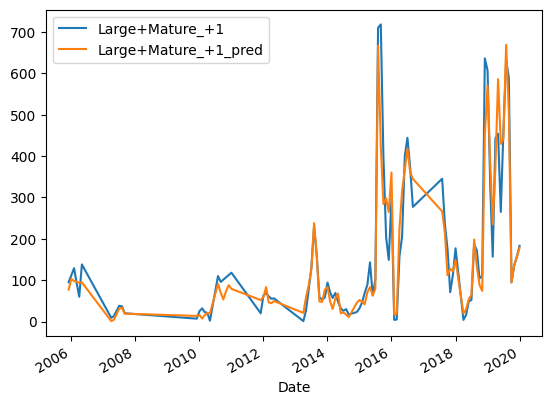

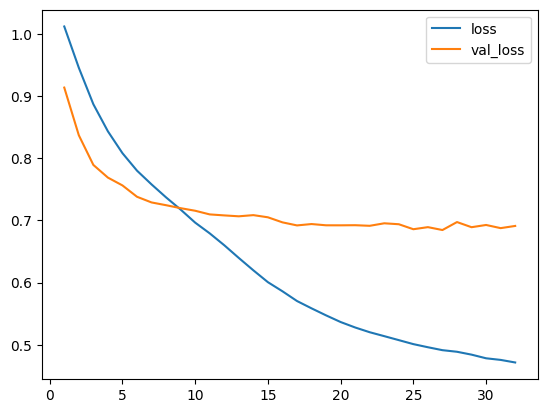

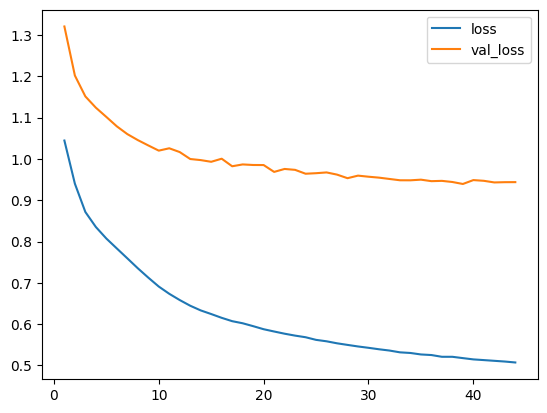

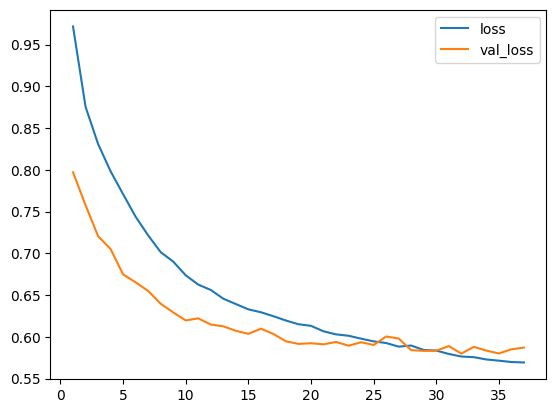

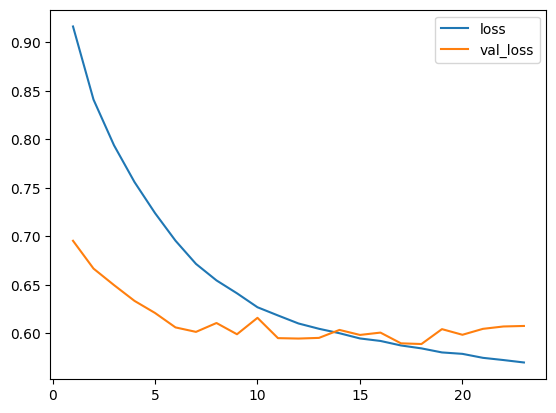

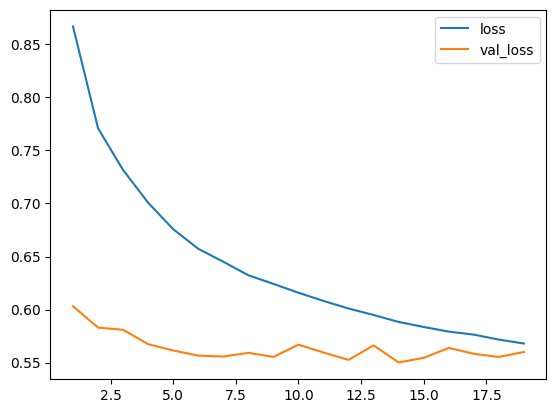

In [124]:
make_date_index(tbl_preds_DNN)
tbl_preds_DNN[(tbl_preds_DNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_DNN[tbl_history_DNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Raw data - optimization

In [89]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10113837/
DNN_params = {
    "neurons_layer": list(range(5, 100, 1)),
    # "neurons_layer": [94], # 94
    # "activation_layer": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "activation_layer": ["relu"], # softplus
    "learning_rate": [x/100000 for x in range(1, 101, 1)],
    # "learning_rate": [0.00014], # 0.00014
    # "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "optimizer": ["Adam"], # Nadam
    "batch_size": list(range(5, 50, 1)),
    "dropout": [x/100 for x in range(1, 101, 1)], # 0.05
    # "batch_size": [18] # 18
}

init_params = {
    "neurons_layer": 16,
    "activation_layer": 'relu',
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20,
    "dropout": 0.5
}

params_best = {
    "neurons_layer": 94,
    "activation_layer": 'softplus',
    "learning_rate": 0.00014,
    "optimizer": 'Nadam',
    "batch_size": 18,
    "dropout": 0.05
}

def build_model_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(Flatten(input_shape=input_dim))
    model.add(Dense(params["neurons_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_layer"], params["activation_layer"]))
    model.add(Dropout(params["dropout"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

deepDNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 91), 12, build_model_DNN, params_best)
deepDNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_layer': 94, 'activation_layer': 'softplus', 'learning_rate': 0.00014, 'optimizer': 'Nadam', 'batch_size': 18, 'dropout': 0.05}
{'neurons_layer': 94, 'activation_layer': 'softplus', 'learning_rate': 0.00014, 'optimizer': 'Nadam', 'batch_size': 18, 'dropout': 0.05}
Model: "sequential_407"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_407 (Flatten)       (None, 91)                0         
                                                                 
 dense_2034 (Dense)          (None, 94)                8648      
                                                                 
 dense_2035 (Dense)          (None, 94)                8930      
                                                                 
 dense_2036 (Dense)          (None, 94)                8930      
                                                                 
 dense_2037 (Dense)          (None, 94)   

In [82]:
DNN_results = deepDNNTimeSeriesForecaster.optimize_model(build_model_DNN, DNN_params, search_method="random")

Searching: 1/60
{'neurons_layer': 83, 'activation_layer': 'relu', 'learning_rate': 0.00058, 'optimizer': <keras.optimizers.adam.Adam object at 0x0000023982BEA1C0>, 'batch_size': 8, 'dropout': 0.15}
Model: "sequential_346"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_346 (Flatten)       (None, 91)                0         
                                                                 
 dense_1729 (Dense)          (None, 83)                7636      
                                                                 
 dense_1730 (Dense)          (None, 83)                6972      
                                                                 
 dense_1731 (Dense)          (None, 83)                6972      
                                                                 
 dense_1732 (Dense)          (None, 83)                6972      
                                                    

In [50]:
DNN_results.to_csv("./Results/data_raw_DNN_optim/optim_results.csv")

In [83]:
DNN_results[DNN_results["mae_mean"] == DNN_results["mae_mean"].min()]

neurons_layer activation_layer  learning_rate  \
10             87             relu        0.00069   

                                            optimizer  batch_size  dropout  \
10  <keras.optimizers.adam.Adam object at 0x000002...          47     0.63   

    rmse_mean  rmse_std   mae_mean   mae_std  wmape_mean  wmape_std   r2_mean  \
10  29.780691  7.177254  18.886196  1.847089     0.57025   0.057555  0.279591   

      r2_std  
10  0.068885

In [84]:
best_params = DNN_results[DNN_results["wmape_mean"] == DNN_results["wmape_mean"].min()]
best_params = best_params.drop(columns=["rmse_mean", "rmse_std", "mae_mean", "mae_std", "wmape_mean", "wmape_std", "r2_mean", "r2_std"])
best_params = best_params.to_dict(orient='records')[0]

In [85]:
best_params["optimizer"] = 'Adam'

In [90]:
DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 91), 12, build_model_DNN, params_best)
DNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_layer': 94, 'activation_layer': 'softplus', 'learning_rate': 0.00014, 'optimizer': 'Nadam', 'batch_size': 18, 'dropout': 0.05}
{'neurons_layer': 94, 'activation_layer': 'softplus', 'learning_rate': 0.00014, 'optimizer': 'Nadam', 'batch_size': 18, 'dropout': 0.05}
Model: "sequential_408"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_408 (Flatten)       (None, 91)                0         
                                                                 
 dense_2039 (Dense)          (None, 94)                8648      
                                                                 
 dense_2040 (Dense)          (None, 94)                8930      
                                                                 
 dense_2041 (Dense)          (None, 94)                8930      
                                                                 
 dense_2042 (Dense)          (None, 94)   

In [91]:
model_DNN_optim, tbl_preds_DNN_optim, tbl_scores_DNN_optim, tbl_history_DNN_optim = DNNTimeSeriesForecaster.evaluate_model(batch_size=params_best["batch_size"], model_name="data_raw_DNN_optim", save_destination="/Results/data_raw_DNN_optim")

Iteration 1 out of 5
(1578, 1, 91) (1578, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
Epoch 1/1000
88/88 [==============================] - 1s 4ms/step - loss: 1.2484 - root_mean_squared_error: 1.1173 - mean_absolute_error: 0.8011 - val_loss: 0.9978 - val_root_mean_squared_error: 0.9989 - val_mean_absolute_error: 0.6895
Epoch 2/1000
88/88 [==============================] - 0s 3ms/step - loss: 1.0954 - root_mean_squared_error: 1.0466 - mean_absolute_error: 0.7312 - val_loss: 0.9785 - val_root_mean_squared_error: 0.9892 - val_mean_absolute_error: 0.6910
Epoch 3/1000
88/88 [==============================] - 0s 3ms/step - loss: 1.0671 - root_mean_squared_error: 1.0330 - mean_absolute_error: 0.7222 - val_loss: 0.9626 - val_root_mean_squared_error: 0.9811 - val_mean_absolute_error: 0.6691
Epoch 4/1000
88/88 [==============================] - 0s 3ms/step - loss: 1.0404 - root_mean_squared_error: 1.0200 - mean_absolute_error: 0.7083 - val_loss: 0.9352 - val_root_mean_squared_error: 0.967

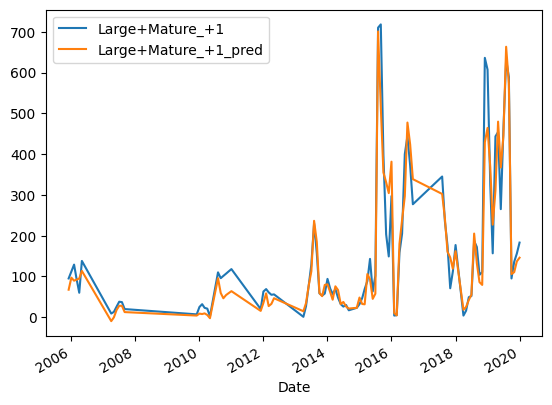

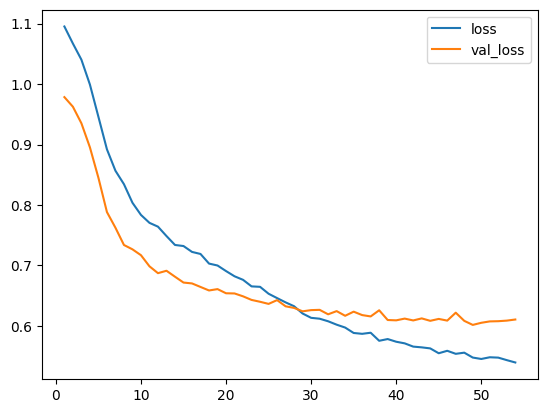

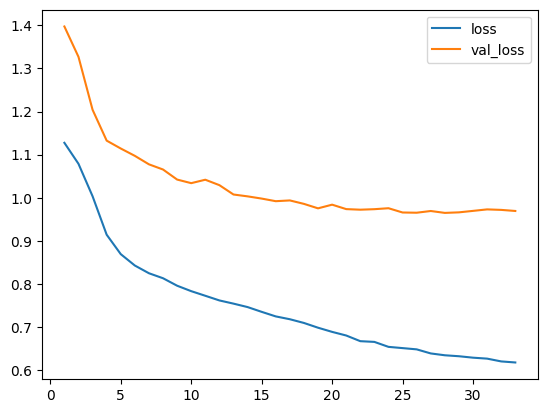

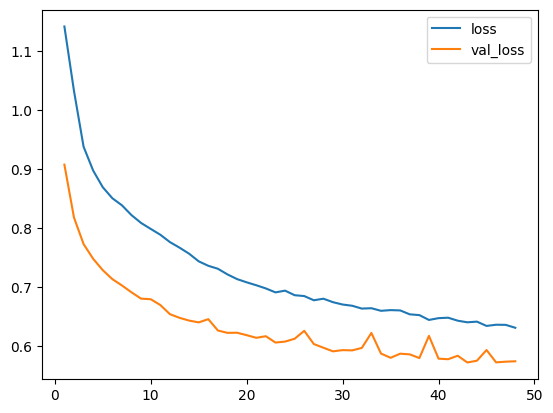

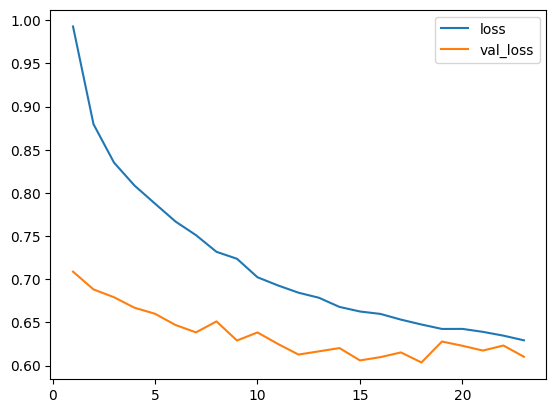

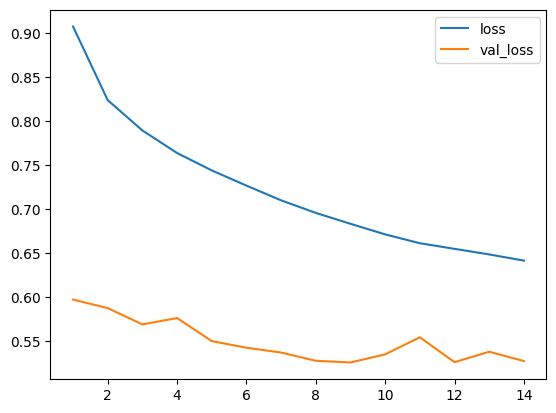

In [92]:
make_date_index(tbl_preds_DNN_optim)
tbl_preds_DNN_optim[(tbl_preds_DNN_optim["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_DNN_optim[tbl_history_DNN_optim["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Feature selection - no optim

In [125]:
init_params = {
    "neurons_1_layer": 16,
    "neurons_2_layer": 16,
    "neurons_3_layer": 16,
    "neurons_4_layer": 16,
    "activation_layer": 'relu',
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(Flatten(input_shape=input_dim))
    model.add(Dense(params["neurons_1_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_2_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_3_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_4_layer"], params["activation_layer"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

deepDNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 125), 12, build_model_DNN, init_params)
deepDNNTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_1_layer': 16, 'neurons_2_layer': 16, 'neurons_3_layer': 16, 'neurons_4_layer': 16, 'activation_layer': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_1_layer': 16, 'neurons_2_layer': 16, 'neurons_3_layer': 16, 'neurons_4_layer': 16, 'activation_layer': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 125)               0         
                                                                 
 dense_59 (Dense)            (None, 16)                2016      
                                                                 
 dense_60 (Dense)            (None, 16)                272       
                                                                 
 dense_61 (Dense)            (None, 16)                272       
             

In [126]:
model_DNN, tbl_preds_DNN, tbl_scores_DNN, tbl_history_DNN = deepDNNTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_FE_FS_DNN_no_optim", save_destination="/Results/data_FE_FS_DNN_no_optim")

Iteration 1 out of 5
(1508, 1, 125) (1508, 12) (928, 1, 125) (928, 12) (408, 1, 125) (408, 12)
Epoch 1/1000
76/76 [==============================] - 1s 4ms/step - loss: 1.0645 - root_mean_squared_error: 1.0318 - mean_absolute_error: 0.7082 - val_loss: 0.9893 - val_root_mean_squared_error: 0.9946 - val_mean_absolute_error: 0.6804
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.9988 - root_mean_squared_error: 0.9994 - mean_absolute_error: 0.6853 - val_loss: 0.9471 - val_root_mean_squared_error: 0.9732 - val_mean_absolute_error: 0.6643
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.9552 - root_mean_squared_error: 0.9774 - mean_absolute_error: 0.6666 - val_loss: 0.8981 - val_root_mean_squared_error: 0.9477 - val_mean_absolute_error: 0.6419
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.9077 - root_mean_squared_error: 0.9527 - mean_absolute_error: 0.6431 - val_loss: 0.8457 - val_root_mean_squared_error: 0.

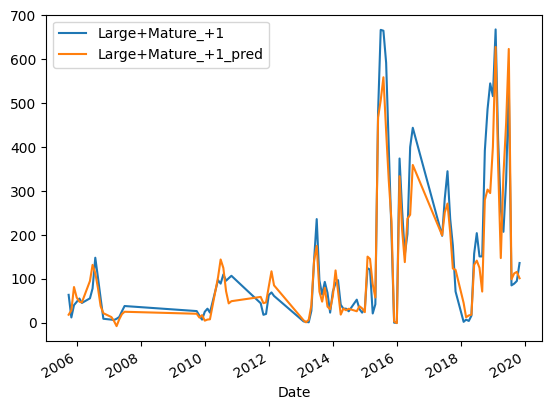

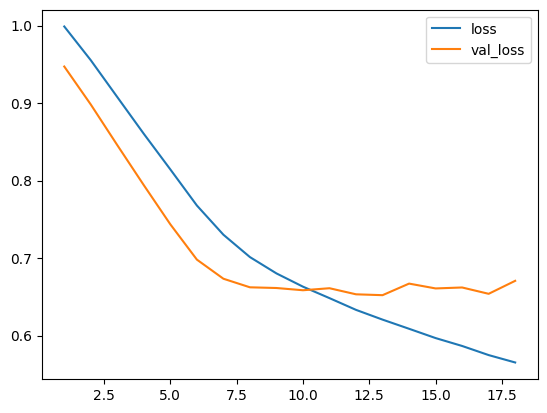

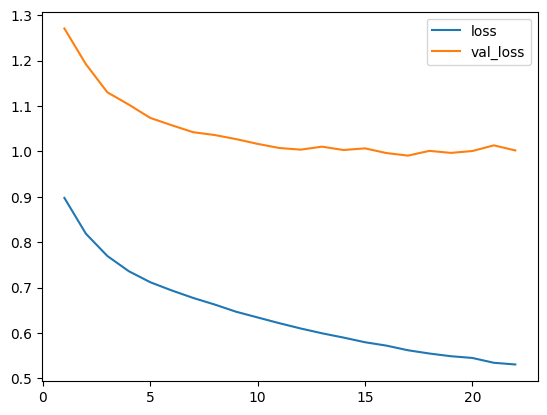

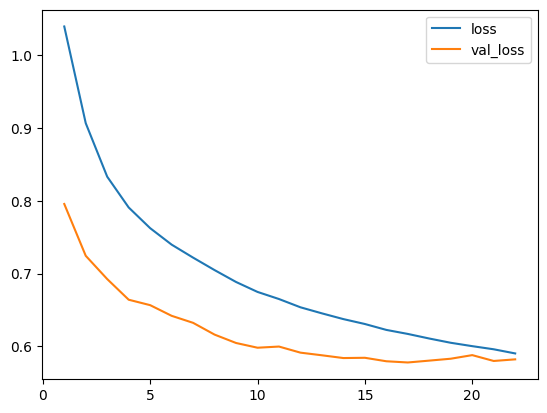

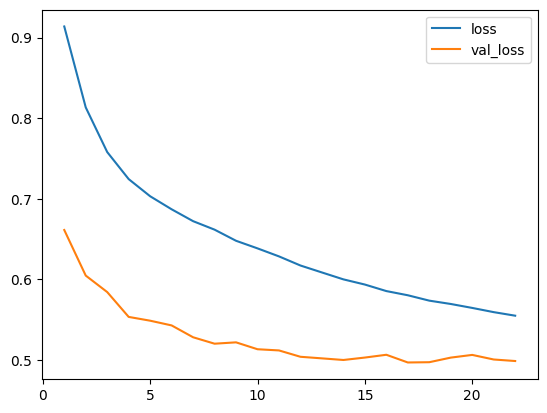

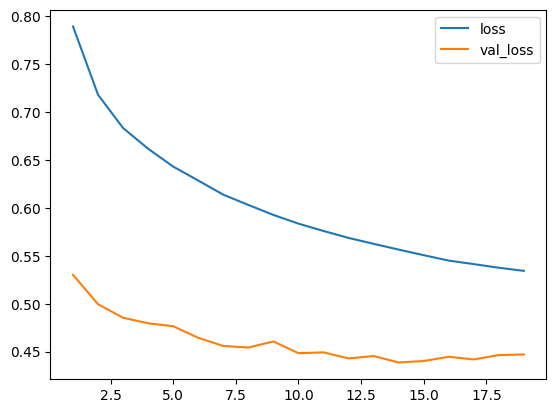

In [127]:
make_date_index(tbl_preds_DNN)
tbl_preds_DNN[(tbl_preds_DNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_DNN[tbl_history_DNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Feature selection - optim

In [72]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10113837/
DNN_params = {
    "neurons_layer": list(range(5, 100, 1)),
    # "neurons_layer": [16],
    # "activation_layer": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "activation_layer": ["linear"],
    "learning_rate": [x/100000 for x in range(1, 101, 1)],
    # "learning_rate": [0.0005],
    # "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "optimizer": ["Adagrad"],
    "batch_size": list(range(5, 50, 1)),
    "dropout": [x/100 for x in range(1, 100, 1)],
    # "batch_size": [20]
}

init_params = {
    "neurons_layer": 16,
    "activation_layer": 'relu',
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20,
    "dropout": 0.5
}

def build_model_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(Flatten(input_shape=input_dim))
    model.add(Dense(params["neurons_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_layer"], params["activation_layer"]))
    model.add(Dense(params["neurons_layer"], params["activation_layer"]))
    model.add(Dropout(params["dropout"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

deepDNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 125), 12, build_model_DNN, init_params)
deepDNNTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_layer': 16, 'activation_layer': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20, 'dropout': 0.5}
{'neurons_layer': 16, 'activation_layer': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20, 'dropout': 0.5}
Model: "sequential_283"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_283 (Flatten)       (None, 125)               0         
                                                                 
 dense_1414 (Dense)          (None, 16)                2016      
                                                                 
 dense_1415 (Dense)          (None, 16)                272       
                                                                 
 dense_1416 (Dense)          (None, 16)                272       
                                                                 
 dense_1417 (Dense)          (None, 16)                2

In [73]:
DNN_results = deepDNNTimeSeriesForecaster.optimize_model(build_model_DNN, DNN_params, input_dim=(1, 125), search_method="random")

Searching: 1/60
{'neurons_layer': 28, 'activation_layer': 'linear', 'learning_rate': 0.00047, 'optimizer': <keras.optimizers.adagrad.Adagrad object at 0x0000023983CD76D0>, 'batch_size': 42, 'dropout': 0.43}
Model: "sequential_284"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_284 (Flatten)       (None, 125)               0         
                                                                 
 dense_1419 (Dense)          (None, 28)                3528      
                                                                 
 dense_1420 (Dense)          (None, 28)                812       
                                                                 
 dense_1421 (Dense)          (None, 28)                812       
                                                                 
 dense_1422 (Dense)          (None, 28)                812       
                                           

In [93]:
DNN_results.to_csv("./Results/data_FE_FS_DNN_optim/optimal_results.csv")

In [74]:
DNN_results[DNN_results["mae_mean"] == DNN_results["mae_mean"].min()]

neurons_layer activation_layer  learning_rate  \
30             43           linear        0.00067   

                                            optimizer  batch_size  dropout  \
30  <keras.optimizers.adagrad.Adagrad object at 0x...          39     0.46   

    rmse_mean  rmse_std   mae_mean   mae_std  wmape_mean  wmape_std   r2_mean  \
30  29.497276  4.207669  18.903887  1.128458    0.512822    0.02336  0.382325   

      r2_std  
30  0.060419

In [75]:
best_params = DNN_results[DNN_results["wmape_mean"] == DNN_results["wmape_mean"].min()]
best_params = best_params.drop(columns=["rmse_mean", "rmse_std", "mae_mean", "mae_std", "wmape_mean", "wmape_std", "r2_mean", "r2_std"])
best_params = best_params.to_dict(orient='records')[0]

In [76]:
best_params["optimizer"] = "Adagrad"

In [77]:
DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 125), 12, build_model_DNN, best_params)
DNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_layer': 43, 'activation_layer': 'linear', 'learning_rate': 0.00067, 'optimizer': 'Adagrad', 'batch_size': 39, 'dropout': 0.46}
{'neurons_layer': 43, 'activation_layer': 'linear', 'learning_rate': 0.00067, 'optimizer': 'Adagrad', 'batch_size': 39, 'dropout': 0.46}
Model: "sequential_344"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_344 (Flatten)       (None, 125)               0         
                                                                 
 dense_1719 (Dense)          (None, 43)                5418      
                                                                 
 dense_1720 (Dense)          (None, 43)                1892      
                                                                 
 dense_1721 (Dense)          (None, 43)                1892      
                                                                 
 dense_1722 (Dense)          (None, 43)   

In [78]:
model_DNN, tbl_preds_DNN, tbl_scores_DNN, tbl_history_DNN = deepDNNTimeSeriesForecaster.evaluate_model(batch_size=best_params["batch_size"], model_name="data_FE_FS_DNN_optim", save_destination="/Results/data_FE_FS_DNN_optim")

Iteration 1 out of 5
(1508, 1, 125) (1508, 12) (928, 1, 125) (928, 12) (408, 1, 125) (408, 12)
Epoch 1/1000
39/39 [==============================] - 1s 6ms/step - loss: 1.4804 - root_mean_squared_error: 1.2167 - mean_absolute_error: 0.8840 - val_loss: 0.8976 - val_root_mean_squared_error: 0.9474 - val_mean_absolute_error: 0.6769
Epoch 2/1000
39/39 [==============================] - 0s 3ms/step - loss: 1.0413 - root_mean_squared_error: 1.0205 - mean_absolute_error: 0.7194 - val_loss: 0.7557 - val_root_mean_squared_error: 0.8693 - val_mean_absolute_error: 0.6153
Epoch 3/1000
39/39 [==============================] - 0s 3ms/step - loss: 0.9131 - root_mean_squared_error: 0.9555 - mean_absolute_error: 0.6659 - val_loss: 0.6958 - val_root_mean_squared_error: 0.8341 - val_mean_absolute_error: 0.5899
Epoch 4/1000
39/39 [==============================] - 0s 2ms/step - loss: 0.8547 - root_mean_squared_error: 0.9245 - mean_absolute_error: 0.6396 - val_loss: 0.6595 - val_root_mean_squared_error: 0.

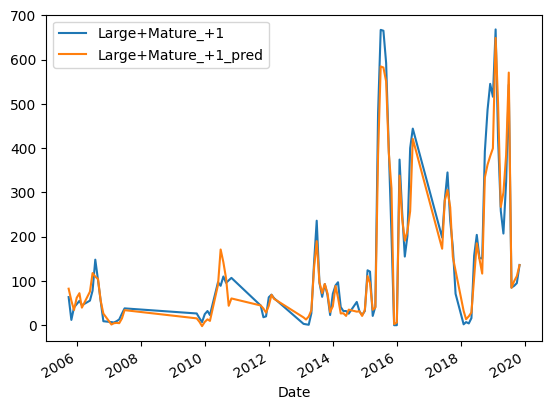

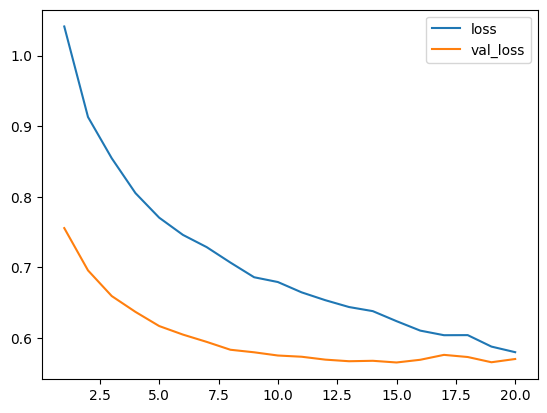

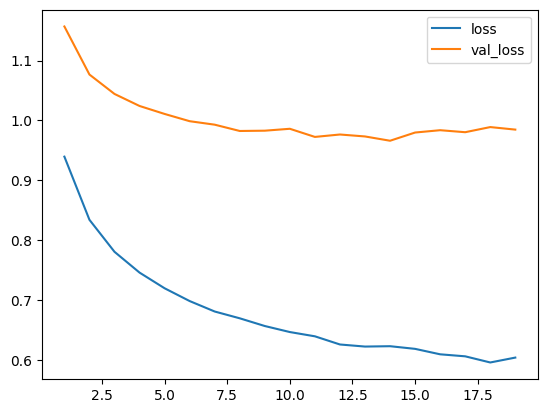

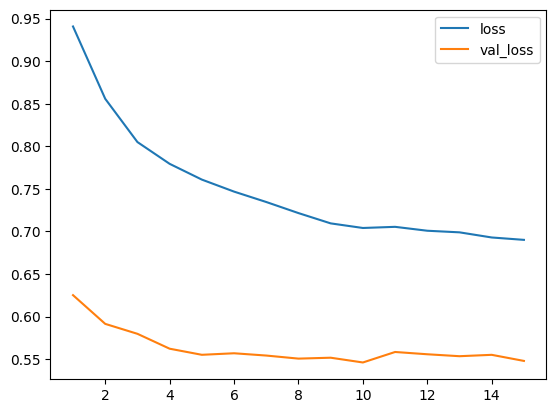

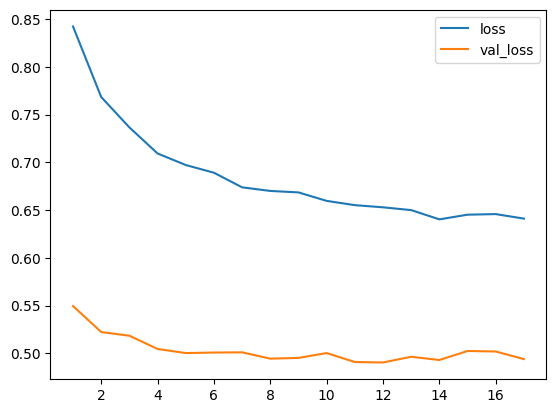

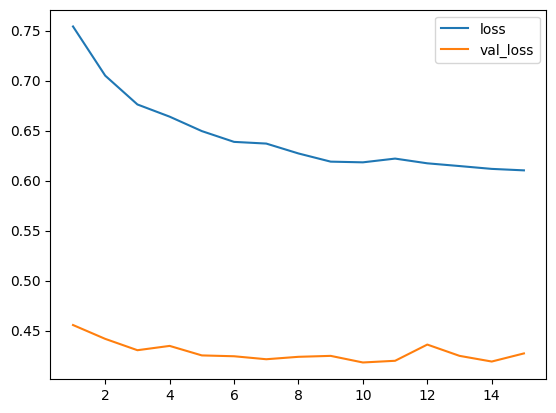

In [79]:
make_date_index(tbl_preds_DNN)
tbl_preds_DNN[(tbl_preds_DNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_DNN[tbl_history_DNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

### LSTM

#### Raw data - no optimization

In [247]:
from keras.regularizers import l2

In [49]:
LSTM_params = {
    "neurons_1_layer": list(range(5, 100, 5)),
    "neurons_2_layer": list(range(5, 100, 5)),
    "activation_1_layer": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "activation_2_layer": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "learning_rate": [x/1000 for x in range(1, 1001, 1)],
    "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "batch_size": [5, 10, 20, 40, 60, 80, 100]
}

In [82]:
init_params = {
    "neurons_LSTM": 16,
    "neurons_dense_1": 16,
    "neurons_dense_2": 16,
    "neurons_dense_3": 16,
    "neurons_dense_4": 16,
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_LSTM(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(LSTM(params["neurons_LSTM"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

LSTMTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((12, 91), 12, build_model_LSTM, init_params)
LSTMTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_LSTM': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_LSTM': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                6912      
                                                                 
 dense_10 (Dense)            (None, 12)                204       
                                                                 
Total params: 7,116
Trainable params: 7,116
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
model_LSTM, tbl_preds_LSTM, tbl_scores_LSTM, tbl_history_LSTM = LSTMTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_raw_LSTM_no_optim", save_destination="/Results/data_raw_LSTM_no_optim", lag=12)

Iteration 1 out of 5
(1566, 12, 91) (1566, 12) (986, 12, 91) (986, 12) (396, 12, 91) (396, 12)
Epoch 1/1000
79/79 [==============================] - 2s 10ms/step - loss: 1.0495 - root_mean_squared_error: 1.0245 - mean_absolute_error: 0.7135 - val_loss: 0.9768 - val_root_mean_squared_error: 0.9883 - val_mean_absolute_error: 0.6896
Epoch 2/1000
79/79 [==============================] - 0s 4ms/step - loss: 0.9709 - root_mean_squared_error: 0.9853 - mean_absolute_error: 0.6831 - val_loss: 0.9401 - val_root_mean_squared_error: 0.9696 - val_mean_absolute_error: 0.6733
Epoch 3/1000
79/79 [==============================] - 0s 4ms/step - loss: 0.9137 - root_mean_squared_error: 0.9559 - mean_absolute_error: 0.6579 - val_loss: 0.9132 - val_root_mean_squared_error: 0.9556 - val_mean_absolute_error: 0.6631
Epoch 4/1000
79/79 [==============================] - 0s 4ms/step - loss: 0.8630 - root_mean_squared_error: 0.9290 - mean_absolute_error: 0.6345 - val_loss: 0.8920 - val_root_mean_squared_error: 0

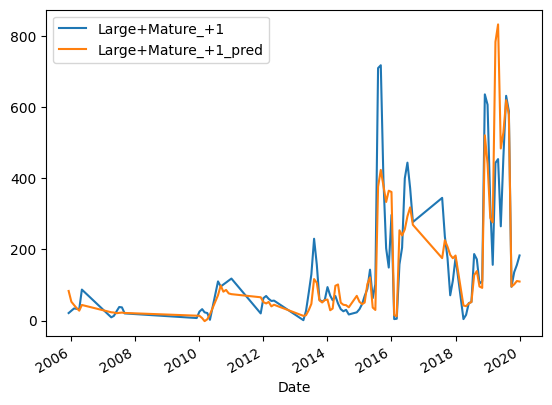

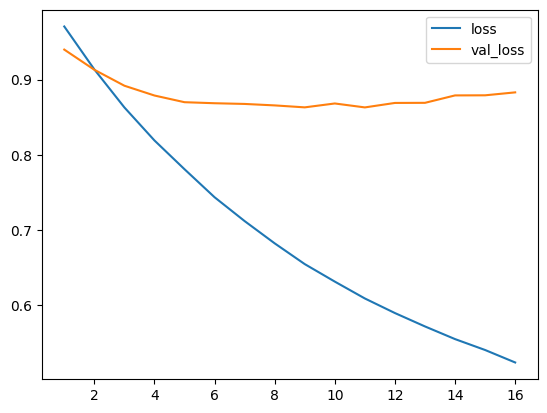

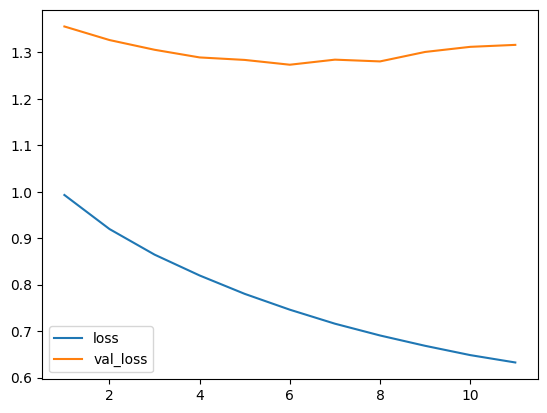

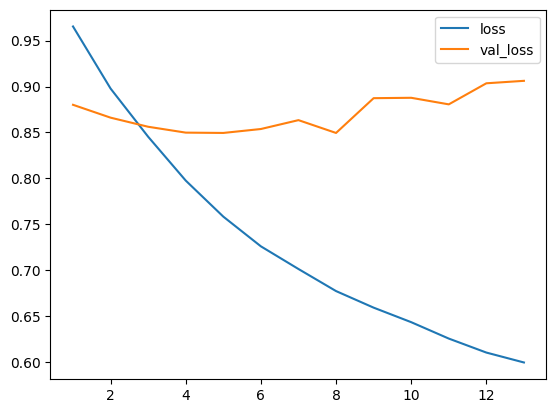

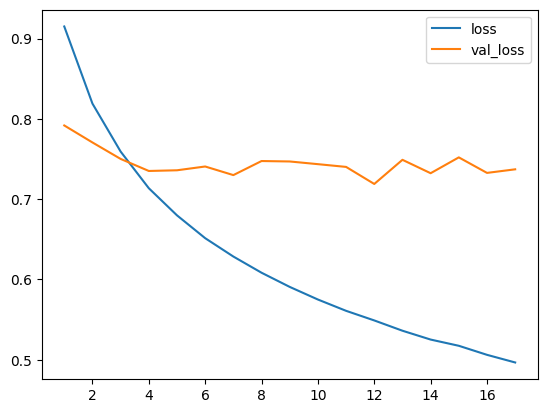

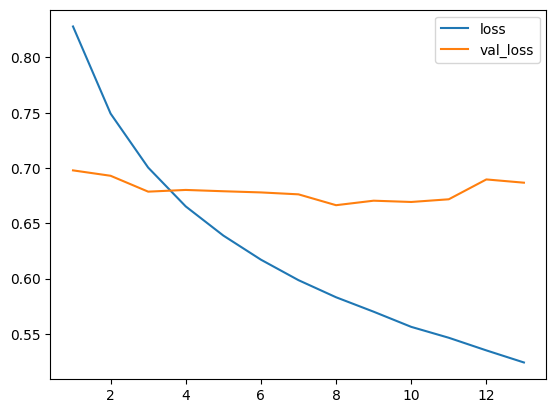

In [84]:
make_date_index(tbl_preds_LSTM)
tbl_preds_LSTM[(tbl_preds_LSTM["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_LSTM[tbl_history_LSTM["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Feature selection - no optim

In [85]:
init_params = {
    "neurons_LSTM": 16,
    "neurons_dense_1": 16,
    "neurons_dense_2": 16,
    "neurons_dense_3": 16,
    "neurons_dense_4": 16,
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_LSTM(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(LSTM(params["neurons_LSTM"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

LSTMTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((12, 125), 12, build_model_LSTM, init_params)
LSTMTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_LSTM': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_LSTM': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                9088      
                                                                 
 dense_11 (Dense)            (None, 12)                204       
                                                                 
Total params: 9,292
Trainable params: 9,292
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
model_LSTM, tbl_preds_LSTM, tbl_scores_LSTM, tbl_history_LSTM = LSTMTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_FE_FS_LSTM_no_optim", save_destination="/Results/data_FE_FS_LSTM_no_optim", lag=12)

Iteration 1 out of 5
(1496, 12, 125) (1496, 12) (916, 12, 125) (916, 12) (396, 12, 125) (396, 12)
Epoch 1/1000
75/75 [==============================] - 2s 8ms/step - loss: 1.0302 - root_mean_squared_error: 1.0150 - mean_absolute_error: 0.7092 - val_loss: 0.9594 - val_root_mean_squared_error: 0.9795 - val_mean_absolute_error: 0.6929
Epoch 2/1000
75/75 [==============================] - 0s 4ms/step - loss: 0.9419 - root_mean_squared_error: 0.9705 - mean_absolute_error: 0.6739 - val_loss: 0.9112 - val_root_mean_squared_error: 0.9546 - val_mean_absolute_error: 0.6714
Epoch 3/1000
75/75 [==============================] - 0s 4ms/step - loss: 0.8861 - root_mean_squared_error: 0.9413 - mean_absolute_error: 0.6510 - val_loss: 0.8832 - val_root_mean_squared_error: 0.9398 - val_mean_absolute_error: 0.6589
Epoch 4/1000
75/75 [==============================] - 0s 4ms/step - loss: 0.8431 - root_mean_squared_error: 0.9182 - mean_absolute_error: 0.6342 - val_loss: 0.8720 - val_root_mean_squared_error:

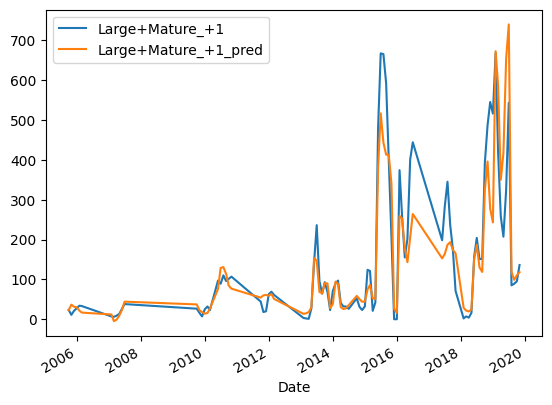

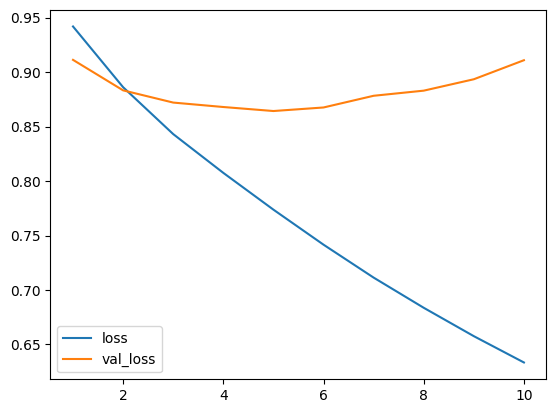

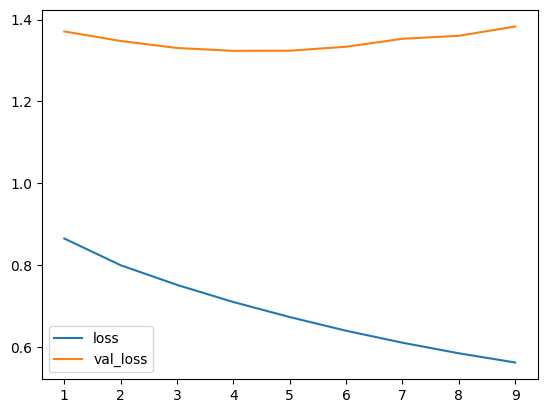

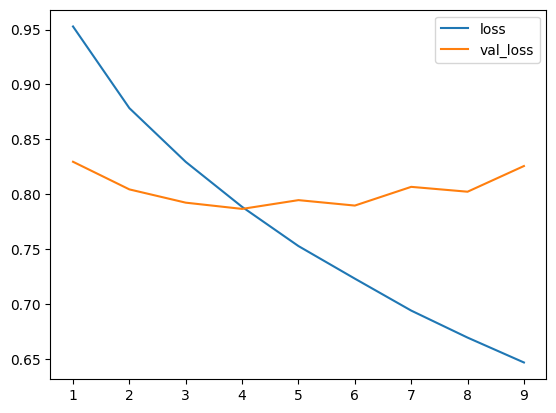

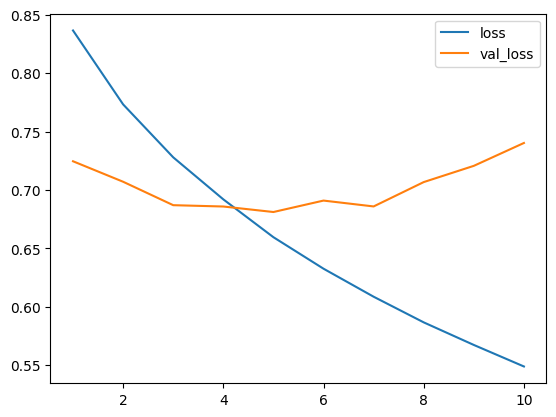

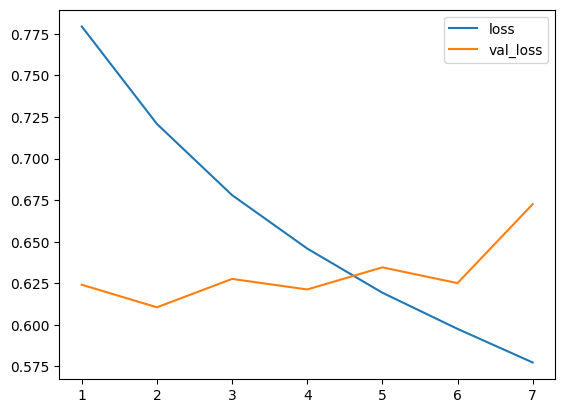

In [87]:
make_date_index(tbl_preds_LSTM)
tbl_preds_LSTM[(tbl_preds_LSTM["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_LSTM[tbl_history_LSTM["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

### LSTM-DNN

#### Raw data - no optim

In [117]:
init_params = {
    "neurons_LSTM": 16,
    "neurons_dense_1": 16,
    "neurons_dense_2": 16,
    "neurons_dense_3": 16,
    "neurons_dense_4": 16,
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_LSTM_DNN(input_dim, output_num, params):
    model = Sequential()
    # model.add(LSTM(params["neurons_LSTM_1"], input_shape=(input_dim), return_sequences=True))
    model.add(InputLayer(input_dim))
    model.add(LSTM(params["neurons_LSTM"]))
    model.add(Flatten())
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_1"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_2"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_3"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_4"], params["activation_dense"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

LSTM_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((12, 91), 12, build_model_LSTM_DNN, init_params)
LSTM_DNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_LSTM': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_LSTM': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 16)                6912      
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
 dense_49 (Dense)            (None, 16)                272       
                                                                 
 dense_50 (Dense)            (None, 16)

In [118]:
model_LSTM_DNN, tbl_preds_LSTM_DNN, tbl_scores_LSTM_DNN, tbl_history_LSTM_DNN = LSTM_DNNTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_raw_LSTM_DNN_no_optim", save_destination="/Results/data_raw_LSTM_DNN_no_optim", lag=12)

Iteration 1 out of 5
(1566, 12, 91) (1566, 12) (986, 12, 91) (986, 12) (396, 12, 91) (396, 12)
Epoch 1/1000
79/79 [==============================] - 2s 9ms/step - loss: 1.0428 - root_mean_squared_error: 1.0212 - mean_absolute_error: 0.7022 - val_loss: 0.9846 - val_root_mean_squared_error: 0.9923 - val_mean_absolute_error: 0.6744
Epoch 2/1000
79/79 [==============================] - 0s 4ms/step - loss: 1.0105 - root_mean_squared_error: 1.0052 - mean_absolute_error: 0.6732 - val_loss: 0.9784 - val_root_mean_squared_error: 0.9891 - val_mean_absolute_error: 0.6487
Epoch 3/1000
79/79 [==============================] - 0s 4ms/step - loss: 0.9787 - root_mean_squared_error: 0.9893 - mean_absolute_error: 0.6443 - val_loss: 0.9579 - val_root_mean_squared_error: 0.9787 - val_mean_absolute_error: 0.6454
Epoch 4/1000
79/79 [==============================] - 0s 4ms/step - loss: 0.9525 - root_mean_squared_error: 0.9759 - mean_absolute_error: 0.6289 - val_loss: 0.9494 - val_root_mean_squared_error: 0.

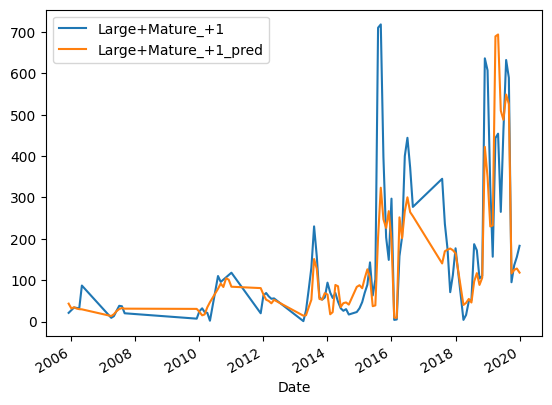

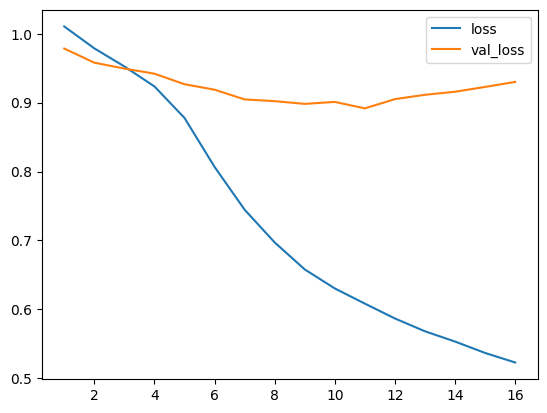

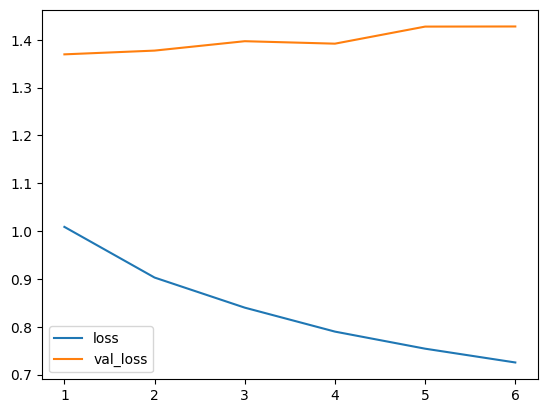

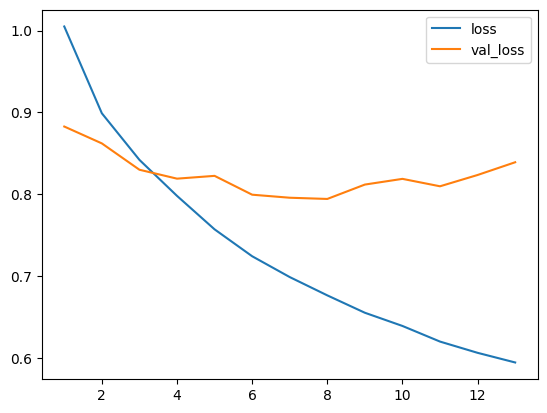

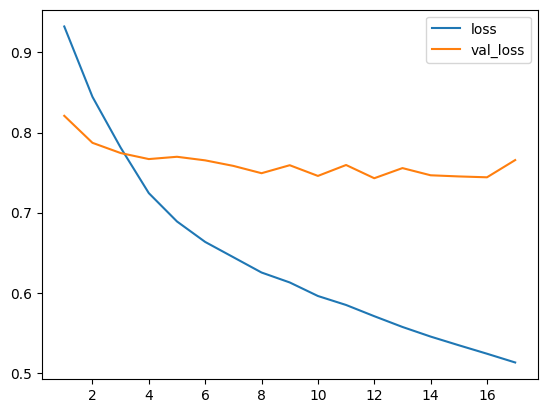

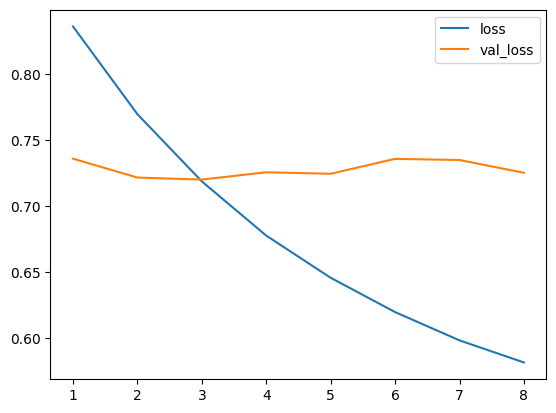

In [119]:
make_date_index(tbl_preds_LSTM_DNN)
tbl_preds_LSTM_DNN[(tbl_preds_LSTM_DNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_LSTM_DNN[tbl_history_LSTM_DNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Raw data - optim

In [135]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10113837/
LSTM_DNN_params = {
    "neurons_LSTM": list(range(5, 100, 1)),
    "neurons_dense": list(range(5, 100, 1)),
    # "neurons_LSTM": [16], # 94
    # "neurons_dense": [16], # 94
    # "activation_dense": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "activation_dense": ["linear"], # linear
    "learning_rate": [x/100000 for x in range(1, 101, 1)],
    # "learning_rate": [0.0005], # 0.00014
    # "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "optimizer": ["Adadelta"], # "Adadelta"
    "batch_size": list(range(5, 50, 1)),
    "dropout": [x/100 for x in range(1, 100, 1)], # 0.05
    # "batch_size": [20] # 18
}

init_params = {
    "neurons_LSTM": 16,
    "neurons_dense": 16,
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "dropout": 0.05,
    "batch_size": 20
}

def build_model_LSTM_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(LSTM(params["neurons_LSTM"]))
    model.add(Flatten())
    model.add(Dense(params["neurons_dense"], params["activation_dense"]))
    model.add(Dense(params["neurons_dense"], params["activation_dense"]))
    model.add(Dense(params["neurons_dense"], params["activation_dense"]))
    model.add(Dense(params["neurons_dense"], params["activation_dense"]))
    model.add(Dropout(params["dropout"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

LSTM_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((3, 91), 12, build_model_LSTM_DNN, init_params)
LSTM_DNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_LSTM': 16, 'neurons_dense': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'dropout': 0.05, 'batch_size': 20}
{'neurons_LSTM': 16, 'neurons_dense': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'dropout': 0.05, 'batch_size': 20}
Model: "sequential_556"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_146 (LSTM)             (None, 16)                6912      
                                                                 
 flatten_555 (Flatten)       (None, 16)                0         
                                                                 
 dense_2768 (Dense)          (None, 16)                272       
                                                                 
 dense_2769 (Dense)          (None, 16)                272       
                                                                 
 dense_2770 (D

Optimizing lag

In [116]:
for i in range(1, 13):
    print(f"lag -> {i}")
    LSTM_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((i, 91), 12, build_model_LSTM_DNN, init_params)
    LSTM_DNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)
    model_LSTM_DNN, tbl_preds_LSTM_DNN, tbl_scores_LSTM_DNN, tbl_history_LSTM_DNN = LSTM_DNNTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name=f"data_raw_LSTM_DNN_optim_lag_{i}", save_destination=f"/Results/data_raw_LSTM_DNN_optim_lag_{i}", lag=i)

lag -> 1
{'neurons_LSTM': 16, 'neurons_dense': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_LSTM': 16, 'neurons_dense': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_480"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 16)                6912      
                                                                 
 flatten_479 (Flatten)       (None, 16)                0         
                                                                 
 dense_2389 (Dense)          (None, 16)                272       
                                                                 
 dense_2390 (Dense)          (None, 16)                272       
                                                                 
 dense_2391 (Dense)          (None, 16)

Optimizing activation and optimizator

In [136]:
LSTM_DNN_results = LSTM_DNNTimeSeriesForecaster.optimize_model(build_model_LSTM_DNN, LSTM_DNN_params, input_dim=(3, 91), search_method = "random", lag=3, num_samples=60)

Searching: 1/60
{'neurons_LSTM': 97, 'neurons_dense': 24, 'activation_dense': 'linear', 'learning_rate': 0.0004, 'optimizer': <keras.optimizers.adadelta.Adadelta object at 0x0000023A29F69A60>, 'batch_size': 25, 'dropout': 0.35}
Model: "sequential_557"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_147 (LSTM)             (None, 97)                73332     
                                                                 
 flatten_556 (Flatten)       (None, 97)                0         
                                                                 
 dense_2773 (Dense)          (None, 24)                2352      
                                                                 
 dense_2774 (Dense)          (None, 24)                600       
                                                                 
 dense_2775 (Dense)          (None, 24)                600       
                      

In [142]:
LSTM_DNN_results.to_csv("./Results/data_raw_LSTM_DNN_optim/opt_results_random.csv")

In [137]:
LSTM_DNN_results[LSTM_DNN_results["wmape_mean"] == LSTM_DNN_results["wmape_mean"].min()]

neurons_LSTM  neurons_dense activation_dense  learning_rate  \
33            90             13           linear        0.00028   

                                            optimizer  batch_size  dropout  \
33  <keras.optimizers.adadelta.Adadelta object at ...           7      0.7   

    rmse_mean  rmse_std  mae_mean   mae_std  wmape_mean  wmape_std  r2_mean  \
33  33.658188  7.447296  22.32771  2.285932    0.673823   0.056274  0.07555   

      r2_std  
33  0.077147

In [138]:
best_params = LSTM_DNN_results[LSTM_DNN_results["wmape_mean"] == LSTM_DNN_results["wmape_mean"].min()]
best_params = best_params.drop(columns=["rmse_mean", "rmse_std", "mae_mean", "mae_std", "wmape_mean", "wmape_std", "r2_mean", "r2_std"])
best_params = best_params.to_dict(orient='records')[0]

In [139]:
best_params["optimizer"] = "Adadelta"

In [140]:
model_LSTM_DNN, tbl_preds_LSTM_DNN, tbl_scores_LSTM_DNN, tbl_history_LSTM_DNN = LSTM_DNNTimeSeriesForecaster.evaluate_model(batch_size=best_params["batch_size"], model_name="data_raw_LSTM_DNN_optim", save_destination="/Results/data_raw_LSTM_DNN_optim", lag=3)

Iteration 1 out of 5
(1575, 3, 91) (1575, 12) (995, 3, 91) (995, 12) (405, 3, 91) (405, 12)
Epoch 1/1000
225/225 [==============================] - 3s 7ms/step - loss: 1.1527 - root_mean_squared_error: 1.0737 - mean_absolute_error: 0.7564 - val_loss: 0.9324 - val_root_mean_squared_error: 0.9656 - val_mean_absolute_error: 0.6707
Epoch 2/1000
225/225 [==============================] - 1s 6ms/step - loss: 1.0316 - root_mean_squared_error: 1.0157 - mean_absolute_error: 0.7095 - val_loss: 0.8893 - val_root_mean_squared_error: 0.9430 - val_mean_absolute_error: 0.6619
Epoch 3/1000
225/225 [==============================] - 1s 6ms/step - loss: 0.9816 - root_mean_squared_error: 0.9908 - mean_absolute_error: 0.6880 - val_loss: 0.8636 - val_root_mean_squared_error: 0.9293 - val_mean_absolute_error: 0.6502
Epoch 4/1000
225/225 [==============================] - 2s 7ms/step - loss: 0.9434 - root_mean_squared_error: 0.9713 - mean_absolute_error: 0.6687 - val_loss: 0.8575 - val_root_mean_squared_erro

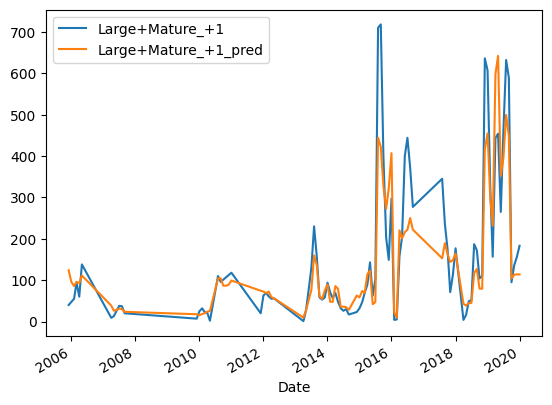

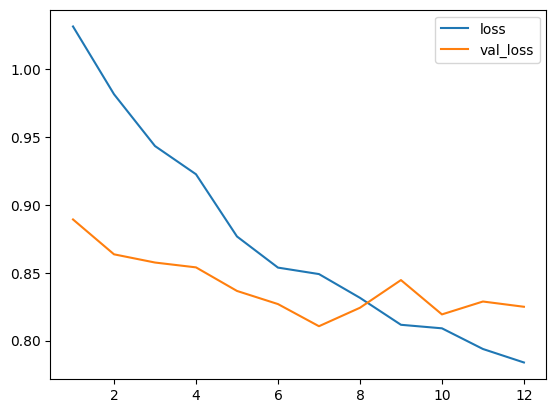

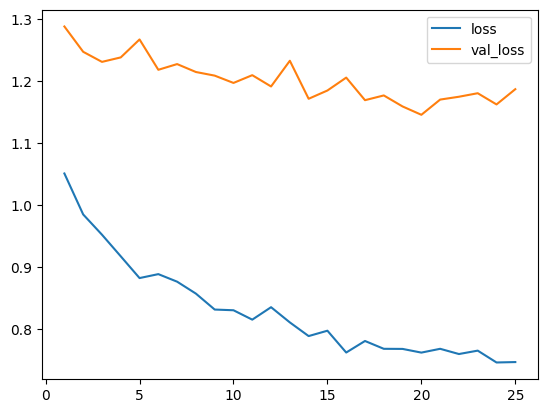

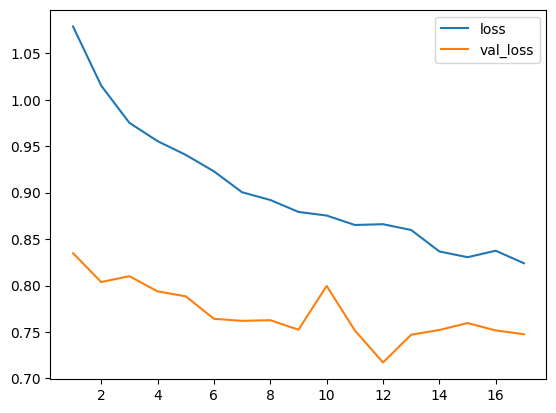

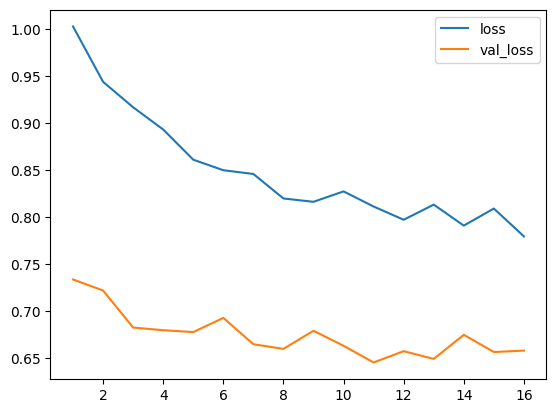

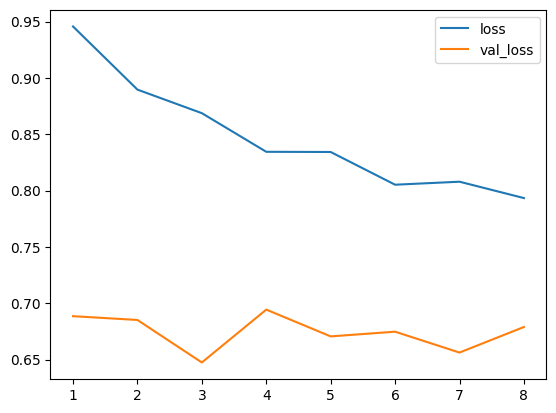

In [141]:
make_date_index(tbl_preds_LSTM_DNN)
tbl_preds_LSTM_DNN[(tbl_preds_LSTM_DNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_LSTM_DNN[tbl_history_LSTM_DNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Feature selection - no optim

In [165]:
init_params = {
    "neurons_LSTM": 16,
    "neurons_dense_1": 16,
    "neurons_dense_2": 16,
    "neurons_dense_3": 16,
    "neurons_dense_4": 16,
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_LSTM_DNN(input_dim, output_num, params):
    model = Sequential()
    # model.add(LSTM(params["neurons_LSTM_1"], input_shape=(input_dim), return_sequences=True))
    model.add(InputLayer(input_dim))
    model.add(LSTM(params["neurons_LSTM"]))
    model.add(Flatten())
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_1"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_2"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_3"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_4"], params["activation_dense"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

LSTM_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((12, 125), 12, build_model_LSTM_DNN, init_params)
LSTM_DNNTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_LSTM': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_LSTM': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 16)                9088      
                                                                 
 flatten_19 (Flatten)        (None, 16)                0         
                                                                 
 dense_129 (Dense)           (None, 16)                272       
                                                                 
 dense_130 (Dense)           (None, 16)

In [166]:
model_LSTM_DNN, tbl_preds_LSTM_DNN, tbl_scores_LSTM_DNN, tbl_history_LSTM_DNN = LSTM_DNNTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_FE_FS_LSTM_DNN_no_optim", save_destination="/Results/data_FE_FS_LSTM_DNN_no_optim", lag=12)

Iteration 1 out of 5
(1496, 12, 125) (1496, 12) (916, 12, 125) (916, 12) (396, 12, 125) (396, 12)
Epoch 1/1000
75/75 [==============================] - 2s 9ms/step - loss: 1.0246 - root_mean_squared_error: 1.0122 - mean_absolute_error: 0.7103 - val_loss: 0.9898 - val_root_mean_squared_error: 0.9949 - val_mean_absolute_error: 0.6895
Epoch 2/1000
75/75 [==============================] - 0s 5ms/step - loss: 0.9892 - root_mean_squared_error: 0.9946 - mean_absolute_error: 0.6931 - val_loss: 0.9466 - val_root_mean_squared_error: 0.9729 - val_mean_absolute_error: 0.6758
Epoch 3/1000
75/75 [==============================] - 0s 5ms/step - loss: 0.9143 - root_mean_squared_error: 0.9562 - mean_absolute_error: 0.6649 - val_loss: 0.9042 - val_root_mean_squared_error: 0.9509 - val_mean_absolute_error: 0.6705
Epoch 4/1000
75/75 [==============================] - 0s 5ms/step - loss: 0.8407 - root_mean_squared_error: 0.9169 - mean_absolute_error: 0.6381 - val_loss: 0.8911 - val_root_mean_squared_error:

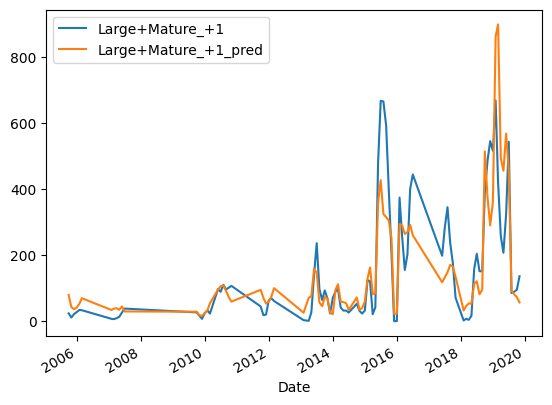

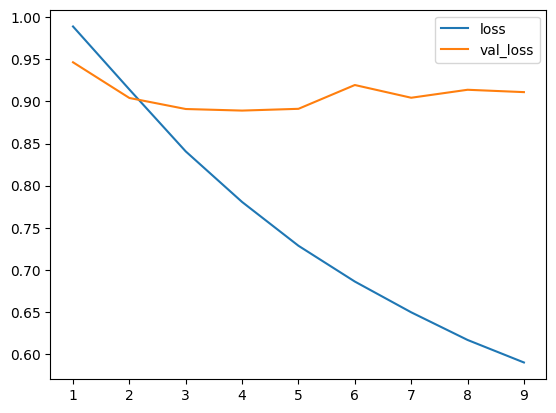

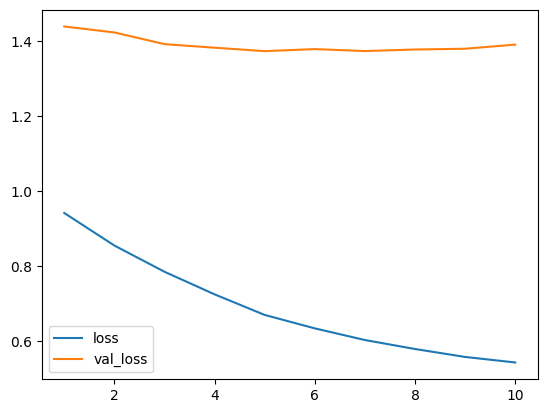

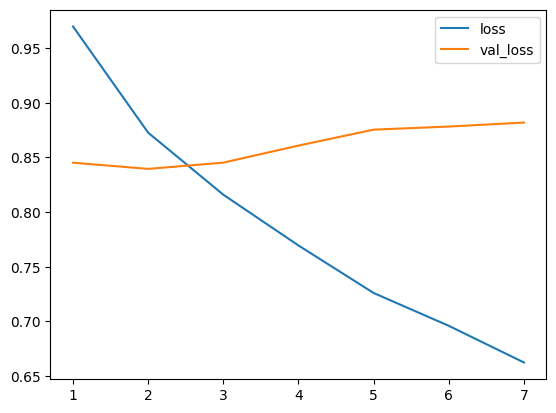

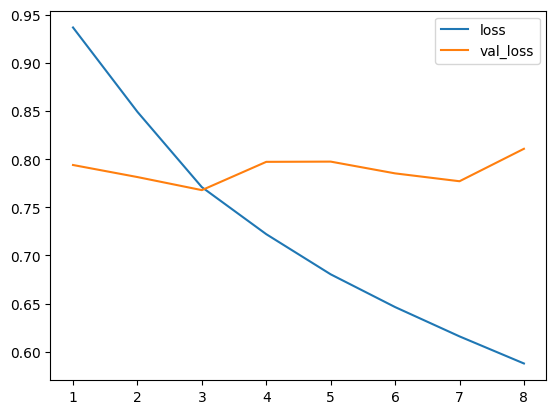

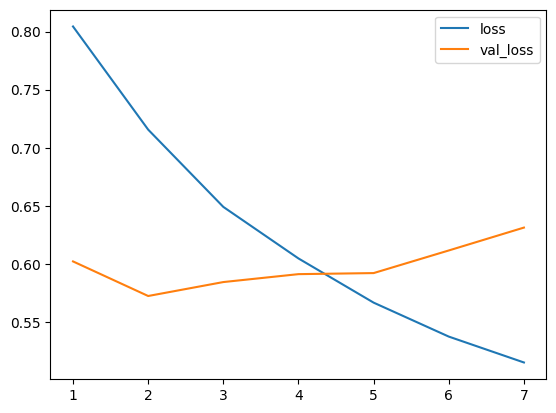

In [167]:
make_date_index(tbl_preds_LSTM_DNN)
tbl_preds_LSTM_DNN[(tbl_preds_LSTM_DNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_LSTM_DNN[tbl_history_LSTM_DNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Feature selection - optim

In [171]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10113837/
LSTM_DNN_params = {
    "neurons_LSTM": list(range(5, 100, 1)),
    "neurons_dense": list(range(5, 100, 1)),
    # "neurons_LSTM": [16], # 94
    # "neurons_dense": [16], # 94
    # "activation_dense": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "activation_dense": ["linear"],
    "learning_rate": [x/100000 for x in range(1, 101, 1)],
    # "learning_rate": [0.0005], # 0.00014
    # "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "optimizer": ["Adagrad"],
    "batch_size": list(range(5, 50, 1)),
    "dropout": [x/100 for x in range(1, 100, 1)], # 0.05
    # "batch_size": [20] # 18
}

init_params = {
    "neurons_LSTM": 16,
    "neurons_dense": 16,
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "dropout": 0.05,
    "batch_size": 20
}

def build_model_LSTM_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(LSTM(params["neurons_LSTM"]))
    model.add(Flatten())
    model.add(Dense(params["neurons_dense"], params["activation_dense"]))
    model.add(Dense(params["neurons_dense"], params["activation_dense"]))
    model.add(Dense(params["neurons_dense"], params["activation_dense"]))
    model.add(Dense(params["neurons_dense"], params["activation_dense"]))
    model.add(Dropout(params["dropout"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

LSTM_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((3, 125), 12, build_model_LSTM_DNN, init_params)
LSTM_DNNTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_LSTM': 16, 'neurons_dense': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'dropout': 0.05, 'batch_size': 20}
{'neurons_LSTM': 16, 'neurons_dense': 16, 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'dropout': 0.05, 'batch_size': 20}
Model: "sequential_735"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_325 (LSTM)             (None, 16)                9088      
                                                                 
 flatten_734 (Flatten)       (None, 16)                0         
                                                                 
 dense_3663 (Dense)          (None, 16)                272       
                                                                 
 dense_3664 (Dense)          (None, 16)                272       
                                                                 
 dense_3665 (D

In [154]:
LSTM_DNN_results = LSTM_DNNTimeSeriesForecaster.optimize_model(build_model_LSTM_DNN, LSTM_DNN_params, input_dim=(3, 125), search_method = "random", lag=3, num_samples=60)

Searching: 1/60
{'neurons_LSTM': 48, 'neurons_dense': 9, 'activation_dense': 'linear', 'learning_rate': 0.00015, 'optimizer': <keras.optimizers.adagrad.Adagrad object at 0x0000023A2C315340>, 'batch_size': 35, 'dropout': 0.14}
Model: "sequential_675"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_265 (LSTM)             (None, 48)                33408     
                                                                 
 flatten_674 (Flatten)       (None, 48)                0         
                                                                 
 dense_3363 (Dense)          (None, 9)                 441       
                                                                 
 dense_3364 (Dense)          (None, 9)                 90        
                                                                 
 dense_3365 (Dense)          (None, 9)                 90        
                        

In [159]:
LSTM_DNN_results.to_csv("./Results/data_FE_FS_LSTM_DNN_optim/opt_results_random.csv")

In [174]:
best_params = LSTM_DNN_results[LSTM_DNN_results["wmape_mean"] == LSTM_DNN_results["wmape_mean"].min()]
best_params = best_params.drop(columns=["rmse_mean", "rmse_std", "mae_mean", "mae_std", "wmape_mean", "wmape_std", "r2_mean", "r2_std"])
best_params = best_params.to_dict(orient='records')[0]
LSTM_DNN_results[LSTM_DNN_results["wmape_mean"] == LSTM_DNN_results["wmape_mean"].min()]

neurons_LSTM  neurons_dense activation_dense  learning_rate  \
13            82             63           linear        0.00069   

                                            optimizer  batch_size  dropout  \
13  <keras.optimizers.adagrad.Adagrad object at 0x...          39      0.9   

    rmse_mean  rmse_std   mae_mean   mae_std  wmape_mean  wmape_std   r2_mean  \
13    34.6483  4.679957  23.131777  1.438054    0.628749   0.030943  0.147764   

      r2_std  
13  0.054344

In [175]:
best_params["optimizer"] = "Adagrad"
# best_params["learning_rate"] = 0.00001
# best_params["batch_size"] = 5
# best_params["neurons_LSTM"] = 8
# best_params["neurons_dense"] = 16
best_params["dropout"] = 0.5

In [176]:
LSTM_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((3, 125), 12, build_model_LSTM_DNN, best_params)
LSTM_DNNTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)
model_LSTM_DNN, tbl_preds_LSTM_DNN, tbl_scores_LSTM_DNN, tbl_history_LSTM_DNN = LSTM_DNNTimeSeriesForecaster.evaluate_model(batch_size=best_params["batch_size"], model_name="data_FE_FS_LSTM_DNN_optim", save_destination="/Results/data_FE_FS_LSTM_DNN_optim", lag=3)

{'neurons_LSTM': 82, 'neurons_dense': 63, 'activation_dense': 'linear', 'learning_rate': 0.00069, 'optimizer': 'Adagrad', 'batch_size': 39, 'dropout': 0.5}
{'neurons_LSTM': 82, 'neurons_dense': 63, 'activation_dense': 'linear', 'learning_rate': 0.00069, 'optimizer': 'Adagrad', 'batch_size': 39, 'dropout': 0.5}
Model: "sequential_737"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_327 (LSTM)             (None, 82)                68224     
                                                                 
 flatten_736 (Flatten)       (None, 82)                0         
                                                                 
 dense_3673 (Dense)          (None, 63)                5229      
                                                                 
 dense_3674 (Dense)          (None, 63)                4032      
                                                                 
 den

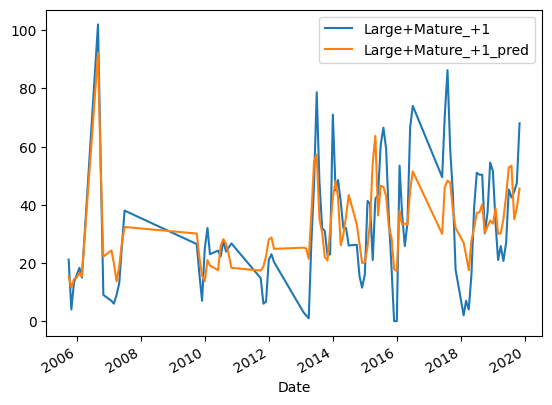

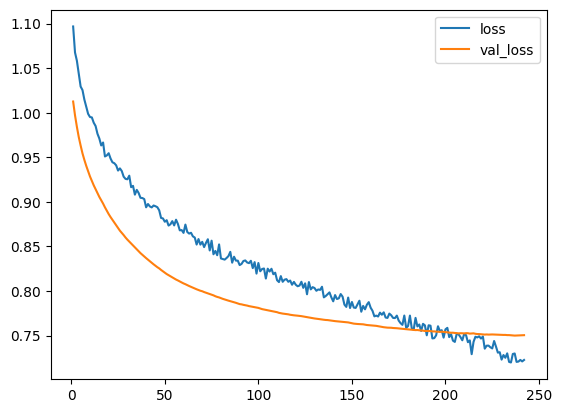

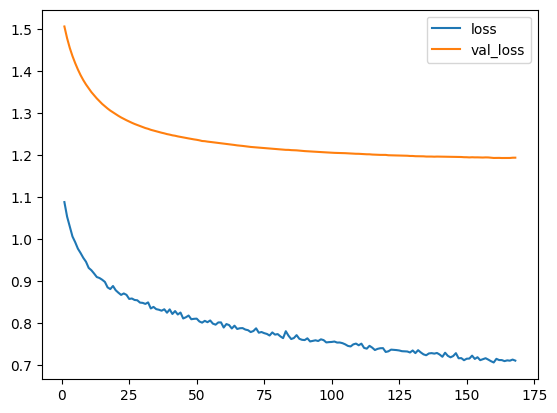

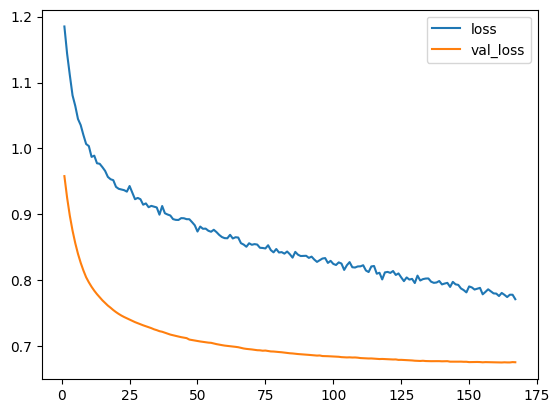

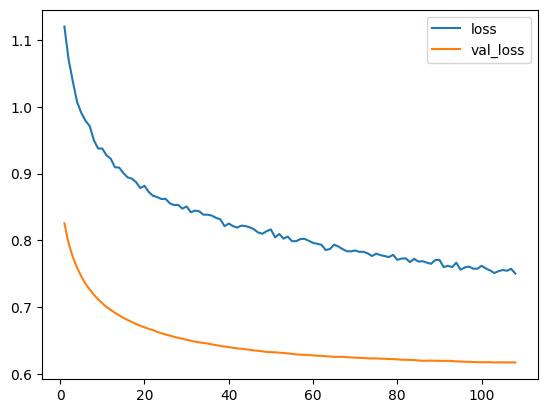

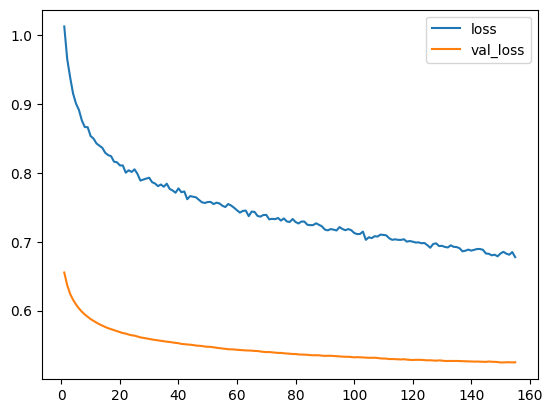

In [177]:
make_date_index(tbl_preds_LSTM_DNN)
tbl_preds_LSTM_DNN[(tbl_preds_LSTM_DNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].mean().plot()
for i in range(1, 6):
    tbl_history_LSTM_DNN[tbl_history_LSTM_DNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

### CNN

#### Raw Data - no optimization

In [95]:
init_params = {
    "neurons_CNN": 16,
    "neurons_dense_1": 16,
    "neurons_dense_2": 16,
    "neurons_dense_3": 16,
    "neurons_dense_4": 16,
    "activation_CNN": "relu",
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

In [96]:
def build_model_CNN(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(Conv1D(params["neurons_CNN"], kernel_size=1, activation=params["activation_CNN"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [97]:
CNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 91), 12, build_model_CNN, init_params)
CNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_CNN': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_CNN': 'relu', 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_CNN': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_CNN': 'relu', 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 16)             1472      
                                                                 
 dense_22 (Dense)            (None, 1, 12)             204       
                                                                 
Total params: 1,676
Trainable params: 1,676
Non-trainable params: 0
______________________________________________________

In [98]:
model_CNN, tbl_preds_CNN, tbl_scores_CNN, tbl_history_CNN = CNNTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_raw_CNN_no_optim", save_destination="/Results/data_raw_CNN_no_optim")

Iteration 1 out of 5
(1578, 1, 91) (1578, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
Epoch 1/1000
79/79 [==============================] - 1s 3ms/step - loss: 1.1587 - root_mean_squared_error: 1.0766 - mean_absolute_error: 0.7485 - val_loss: 1.0671 - val_root_mean_squared_error: 1.0329 - val_mean_absolute_error: 0.7166
Epoch 2/1000
79/79 [==============================] - 0s 2ms/step - loss: 1.0987 - root_mean_squared_error: 1.0484 - mean_absolute_error: 0.7289 - val_loss: 1.0414 - val_root_mean_squared_error: 1.0204 - val_mean_absolute_error: 0.7098
Epoch 3/1000
79/79 [==============================] - 0s 2ms/step - loss: 1.0812 - root_mean_squared_error: 1.0393 - mean_absolute_error: 0.7249 - val_loss: 1.0298 - val_root_mean_squared_error: 1.0147 - val_mean_absolute_error: 0.7065
Epoch 4/1000
79/79 [==============================] - 0s 2ms/step - loss: 1.0731 - root_mean_squared_error: 1.0359 - mean_absolute_error: 0.7222 - val_loss: 1.0234 - val_root_mean_squared_error: 1.011

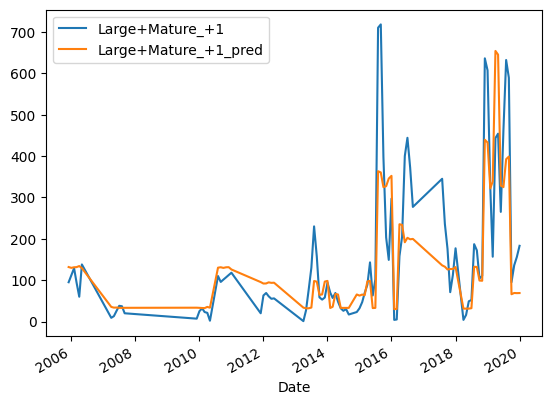

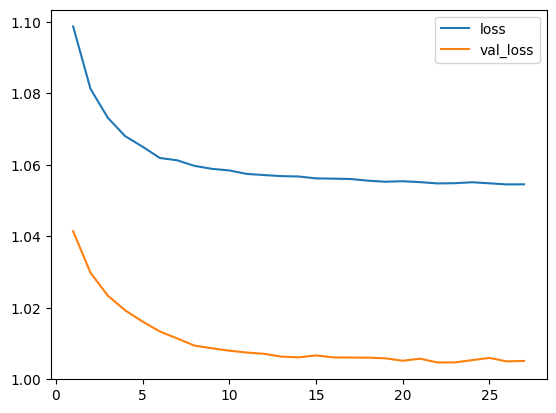

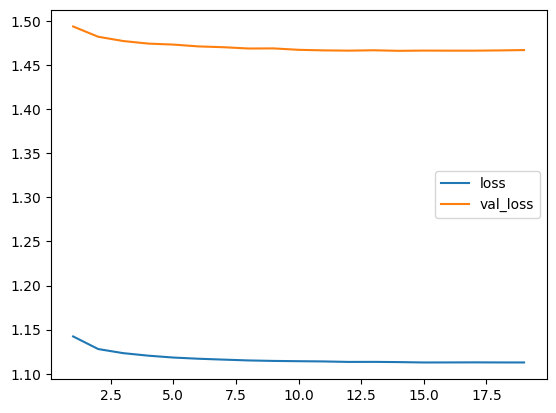

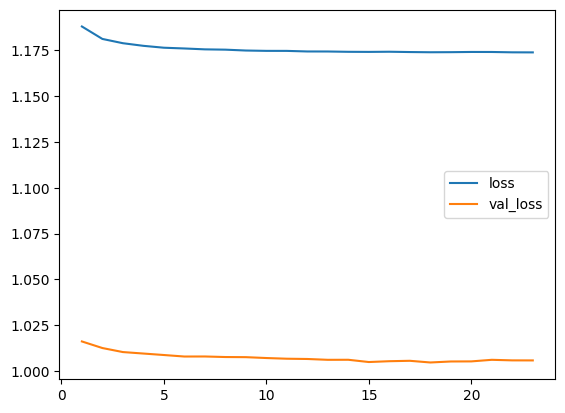

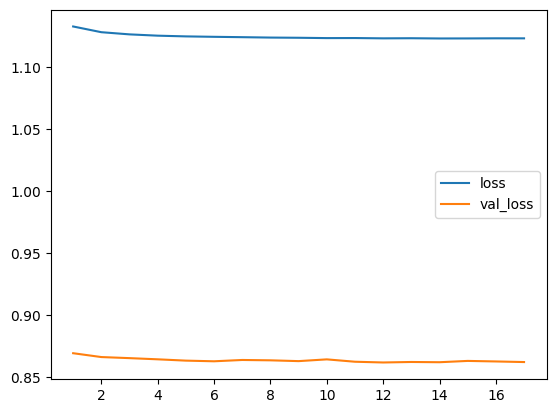

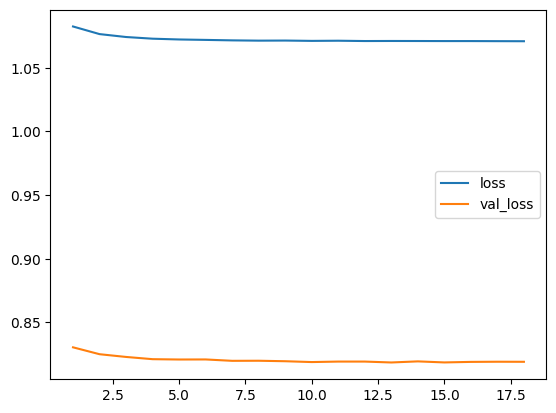

In [99]:
make_date_index(tbl_preds_CNN)
tbl_preds_CNN[(tbl_preds_CNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_CNN[tbl_history_CNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Features after selection - no optim

In [100]:
init_params = {
    "neurons_CNN": 16,
    "neurons_dense_1": 16,
    "neurons_dense_2": 16,
    "neurons_dense_3": 16,
    "neurons_dense_4": 16,
    "activation_CNN": "relu",
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_CNN(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(Conv1D(params["neurons_CNN"], kernel_size=1, activation=params["activation_CNN"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

CNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 125), 12, build_model_CNN, init_params)
CNNTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_CNN': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_CNN': 'relu', 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_CNN': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_CNN': 'relu', 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 16)             2016      
                                                                 
 dense_23 (Dense)            (None, 1, 12)             204       
                                                                 
Total params: 2,220
Trainable params: 2,220
Non-trainable params: 0
______________________________________________________

In [101]:
model_CNN, tbl_preds_CNN, tbl_scores_CNN, tbl_history_CNN = CNNTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_FE_FS_CNN_no_optim", save_destination="/Results/data_FE_FS_CNN_no_optim")

Iteration 1 out of 5
(1508, 1, 125) (1508, 12) (928, 1, 125) (928, 12) (408, 1, 125) (408, 12)
Epoch 1/1000
76/76 [==============================] - 1s 3ms/step - loss: 1.3904 - root_mean_squared_error: 1.1800 - mean_absolute_error: 0.8484 - val_loss: 1.2651 - val_root_mean_squared_error: 1.1256 - val_mean_absolute_error: 0.7831
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 1.1767 - root_mean_squared_error: 1.0851 - mean_absolute_error: 0.7678 - val_loss: 1.1395 - val_root_mean_squared_error: 1.0682 - val_mean_absolute_error: 0.7428
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 1.1138 - root_mean_squared_error: 1.0558 - mean_absolute_error: 0.7456 - val_loss: 1.0845 - val_root_mean_squared_error: 1.0421 - val_mean_absolute_error: 0.7264
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 1.0864 - root_mean_squared_error: 1.0430 - mean_absolute_error: 0.7364 - val_loss: 1.0568 - val_root_mean_squared_error: 1.

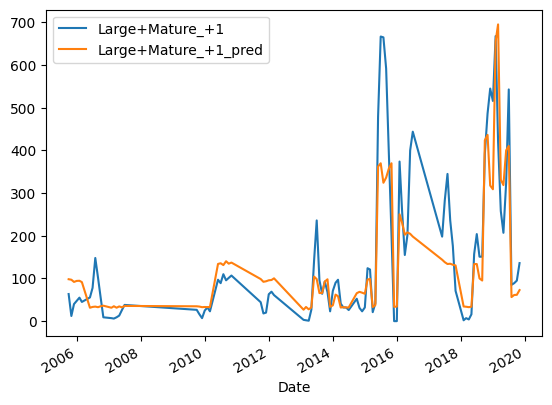

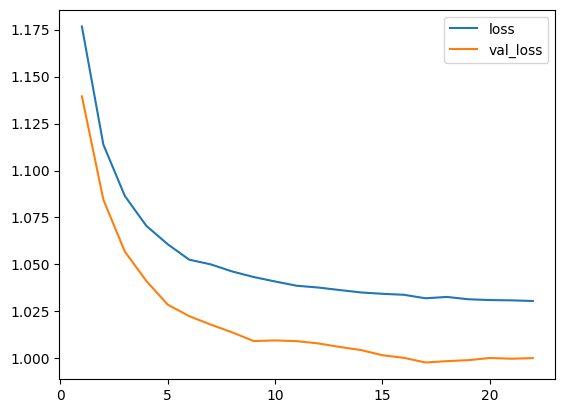

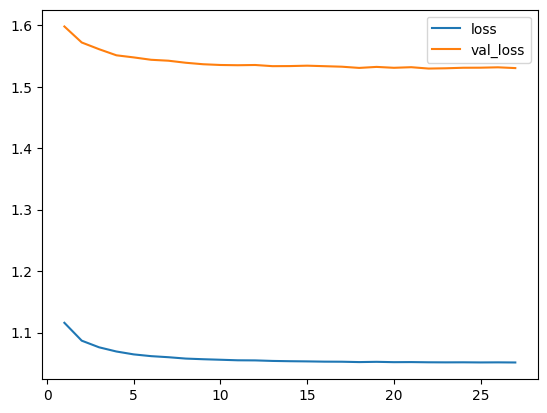

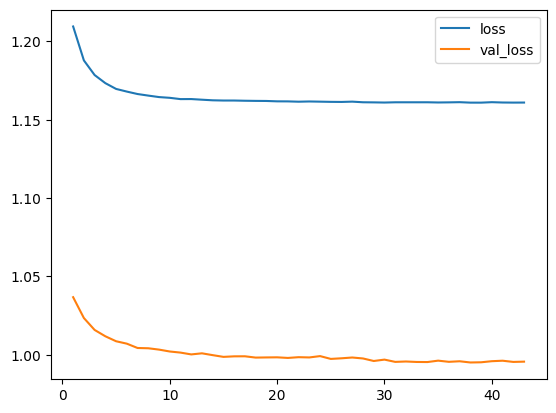

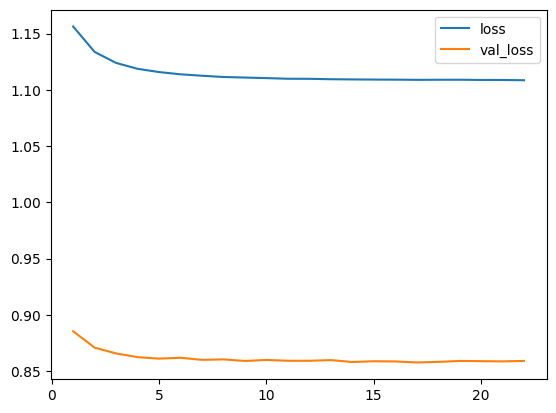

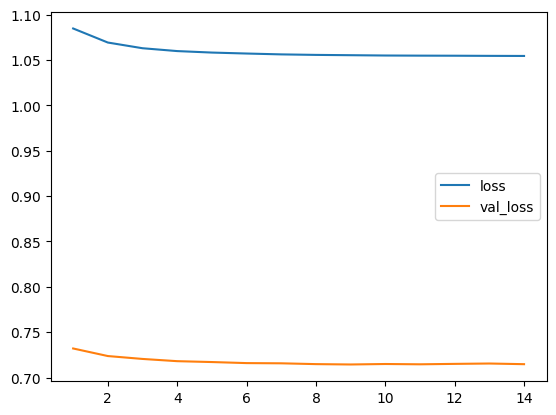

In [102]:
make_date_index(tbl_preds_CNN)
tbl_preds_CNN[(tbl_preds_CNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_CNN[tbl_history_CNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

### CNN-DNN

#### Raw Data - no optimization

In [159]:
init_params = {
    "neurons_CNN": 16,
    "neurons_dense_1": 16,
    "neurons_dense_2": 16,
    "neurons_dense_3": 16,
    "neurons_dense_4": 16,
    "activation_CNN": "relu",
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_CNN_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(Conv1D(params["neurons_CNN"], kernel_size=1, activation=params["activation_CNN"]))
    model.add(Flatten())
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_1"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_2"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_3"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_4"], params["activation_dense"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

CNN_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 91), 12, build_model_CNN_DNN, init_params)
CNN_DNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_CNN': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_CNN': 'relu', 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_CNN': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_CNN': 'relu', 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 1, 16)             1472      
                                                                 
 flatten_17 (Flatten)        (None, 16)                0         
                                                                 
 dense_119 (Dense)           (None, 16)                272       
                                                       

In [160]:
model_CNN_DNN, tbl_preds_CNN_DNN, tbl_scores_CNN_DNN, tbl_history_CNN_DNN = CNN_DNNTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_raw_CNN_DNN_no_optim", save_destination="/Results/data_raw_CNN_DNN_no_optim")

Iteration 1 out of 5
(1578, 1, 91) (1578, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
Epoch 1/1000
79/79 [==============================] - 1s 4ms/step - loss: 1.0498 - root_mean_squared_error: 1.0246 - mean_absolute_error: 0.7180 - val_loss: 0.9935 - val_root_mean_squared_error: 0.9968 - val_mean_absolute_error: 0.6976
Epoch 2/1000
79/79 [==============================] - 0s 2ms/step - loss: 1.0236 - root_mean_squared_error: 1.0117 - mean_absolute_error: 0.7079 - val_loss: 0.9598 - val_root_mean_squared_error: 0.9797 - val_mean_absolute_error: 0.6910
Epoch 3/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.9729 - root_mean_squared_error: 0.9864 - mean_absolute_error: 0.6926 - val_loss: 0.8925 - val_root_mean_squared_error: 0.9447 - val_mean_absolute_error: 0.6626
Epoch 4/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.8949 - root_mean_squared_error: 0.9460 - mean_absolute_error: 0.6567 - val_loss: 0.8205 - val_root_mean_squared_error: 0.905

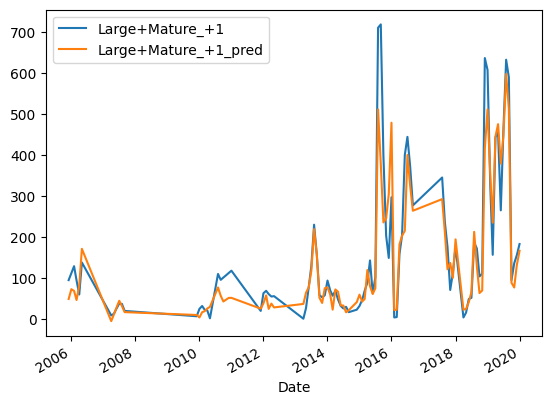

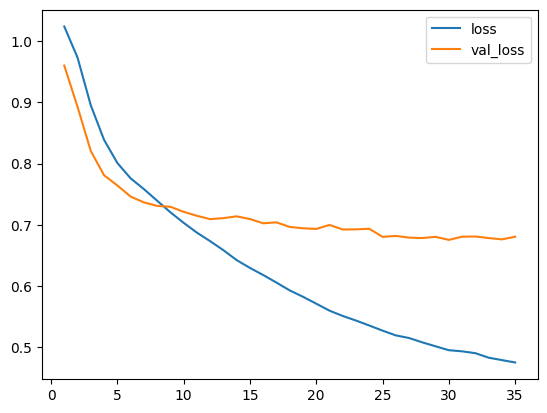

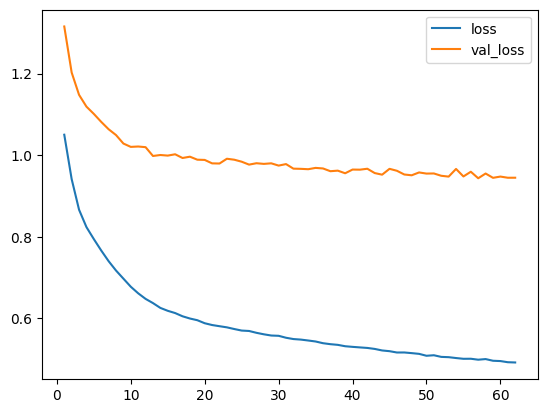

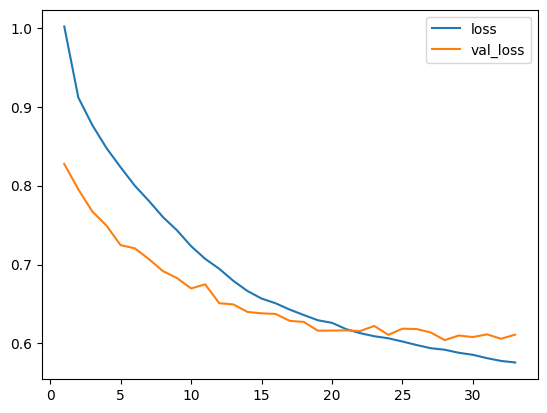

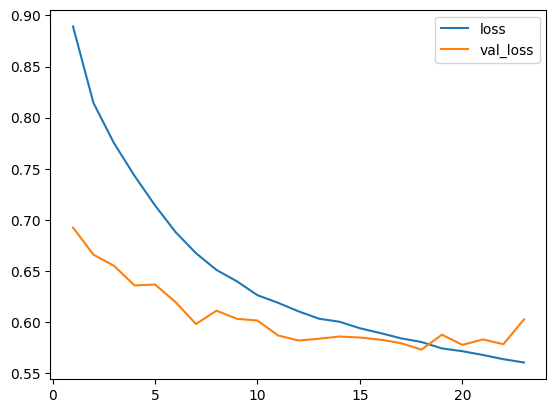

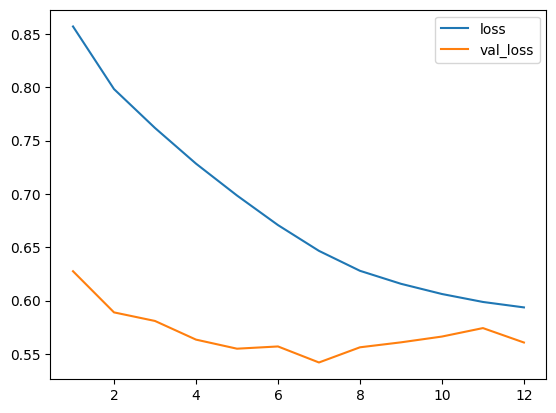

In [161]:
make_date_index(tbl_preds_CNN_DNN)
tbl_preds_CNN_DNN[(tbl_preds_CNN_DNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_CNN_DNN[tbl_history_CNN_DNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Raw Data - optimization

In [18]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10113837/
CNN_DNN_params = {
    "neurons_CNN": list(range(5, 100, 1)),
    "neurons_dense": list(range(5, 100, 1)),
    # "neurons_CNN": [16], # 94
    # "neurons_dense": [16], # 94
    # "activation": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "activation": ["softplus"],
    "learning_rate": [x/100000 for x in range(1, 101, 1)],
    # "learning_rate": [0.0005], # 0.00014
    # "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "optimizer": ["Adagrad"],
    "batch_size": list(range(5, 50, 1)),
    "dropout_rate": [x/100 for x in range(1, 100, 1)], # 0.05
    # "batch_size": [20] # 18
}

init_params = {
    "neurons_CNN": 16,
    "neurons_dense": 16,
    "activation": "relu",
    "dropout_rate": 0.2,
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_CNN_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(Conv1D(params["neurons_CNN"], kernel_size=1, activation=params["activation"]))
    model.add(Flatten())
    model.add(Dense(params["neurons_dense"], params["activation"]))
    model.add(Dense(params["neurons_dense"], params["activation"]))
    model.add(Dense(params["neurons_dense"], params["activation"]))
    model.add(Dense(params["neurons_dense"], params["activation"]))
    model.add(Dropout(params["dropout_rate"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

CNN_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 91), 12, build_model_CNN_DNN, init_params)
CNN_DNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_CNN': 16, 'neurons_dense': 16, 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_CNN': 16, 'neurons_dense': 16, 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 1, 16)             1472      
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dense_11 (Dense)     

In [19]:
CNN_DNN_results = CNN_DNNTimeSeriesForecaster.optimize_model(build_model_CNN_DNN, CNN_DNN_params, input_dim = (1, 91), search_method = "random", num_samples = 60)

Searching: 1/60
{'neurons_CNN': 16, 'neurons_dense': 19, 'activation': 'softplus', 'learning_rate': 0.00075, 'optimizer': <keras.optimizers.adagrad.Adagrad object at 0x00000169D4219040>, 'batch_size': 20, 'dropout_rate': 0.54}
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1, 16)             1472      
                                                                 
 flatten_3 (Flatten)         (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 19)                323       
                                                                 
 dense_15 (Dense)            (None, 19)                380       
                                                                 
 dense_16 (Dense)            (None, 19)                380       
                         

In [21]:
CNN_DNN_results.to_csv("./Results/data_raw_CNN_DNN_optim/opt_results_random.csv")
# CNN_DNN_results = pd.read_csv("./Results/data_raw_CNN_DNN_optim/opt_results_grid.csv").drop(columns=["Unnamed: 0"])

In [20]:
CNN_DNN_results[CNN_DNN_results["wmape_mean"] == CNN_DNN_results["wmape_mean"].min()]

neurons_CNN  neurons_dense activation  learning_rate  \
56           56             89   softplus        0.00022   

                                            optimizer  batch_size  \
56  <keras.optimizers.adagrad.Adagrad object at 0x...          18   

    dropout_rate  rmse_mean  rmse_std  mae_mean   mae_std  wmape_mean  \
56          0.35  30.314597  6.881736  19.03544  2.073291     0.57451   

    wmape_std   r2_mean    r2_std  
56   0.061388  0.248831  0.081437

In [35]:
best_params = CNN_DNN_results[CNN_DNN_results["wmape_mean"] == CNN_DNN_results["wmape_mean"].min()]
best_params = best_params.drop(columns=["rmse_mean", "rmse_std", "mae_mean", "mae_std", "wmape_mean", "wmape_std", "r2_mean", "r2_std"])
best_params = best_params.to_dict(orient='records')[0]
best_params

{'neurons_CNN': 86,
 'neurons_dense': 77,
 'activation': 'softplus',
 'learning_rate': 0.00024,
 'optimizer': <keras.optimizers.adagrad.Adagrad at 0x1c8f79cf220>,
 'batch_size': 14}

In [40]:
# Need to remember that I changed here to other parameters
best_params["optimizer"] = "Adam"
best_params["activation"] = "relu"
best_params["dropout_rate"] = 0.5

In [63]:
CNN_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 91), 12, build_model_CNN_DNN, params_temp)
CNN_DNNTimeSeriesForecaster.prepare_data(data, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_CNN': 86, 'neurons_dense': 77, 'activation': 'relu', 'learning_rate': 0.00024, 'optimizer': 'Adam', 'dropout_rate': 0.5, 'batch_size': 14}
{'neurons_CNN': 86, 'neurons_dense': 77, 'activation': 'relu', 'learning_rate': 0.00024, 'optimizer': 'Adam', 'dropout_rate': 0.5, 'batch_size': 14}
Model: "sequential_196"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_195 (Conv1D)         (None, 1, 86)             7912      
                                                                 
 flatten_195 (Flatten)       (None, 86)                0         
                                                                 
 dense_975 (Dense)           (None, 77)                6699      
                                                                 
 dense_976 (Dense)           (None, 77)                6006      
                                                                 
 dense_977 (Dense)

In [62]:
params_temp = {
    'neurons_CNN': 86,
    'neurons_dense': 77,
    'activation': 'relu',
    'learning_rate': 0.00024,
    'optimizer': "Adam",
    "dropout_rate": 0.5,
    'batch_size': 14
}

In [64]:
model_CNN_DNN_optim, tbl_preds_CNN_DNN_optim, tbl_scores_CNN_DNN_optim, tbl_history_CNN_DNN_optim = CNN_DNNTimeSeriesForecaster.evaluate_model(batch_size=best_params["batch_size"], model_name="data_raw_CNN_DNN_optim", save_destination="/Results/data_raw_CNN_DNN_optim")

Iteration 1 out of 5
(1578, 1, 91) (1578, 12) (998, 1, 91) (998, 12) (408, 1, 91) (408, 12)
Epoch 1/1000
33/33 [==============================] - 1s 7ms/step - loss: 1.0601 - root_mean_squared_error: 1.0296 - mean_absolute_error: 0.7162 - val_loss: 0.9879 - val_root_mean_squared_error: 0.9939 - val_mean_absolute_error: 0.6911
Epoch 2/1000
33/33 [==============================] - 0s 3ms/step - loss: 1.0229 - root_mean_squared_error: 1.0114 - mean_absolute_error: 0.6985 - val_loss: 0.9504 - val_root_mean_squared_error: 0.9749 - val_mean_absolute_error: 0.6687
Epoch 3/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.9815 - root_mean_squared_error: 0.9907 - mean_absolute_error: 0.6746 - val_loss: 0.8843 - val_root_mean_squared_error: 0.9404 - val_mean_absolute_error: 0.6373
Epoch 4/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.9272 - root_mean_squared_error: 0.9629 - mean_absolute_error: 0.6479 - val_loss: 0.8295 - val_root_mean_squared_error: 0.910

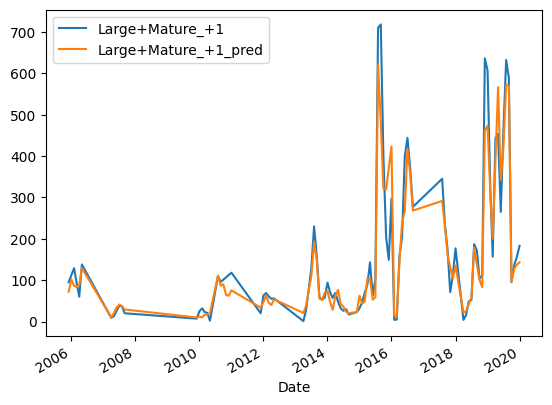

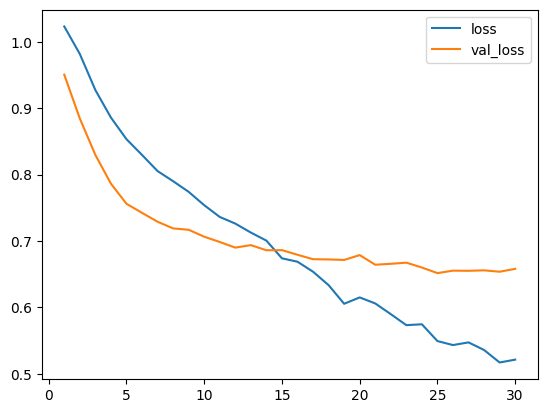

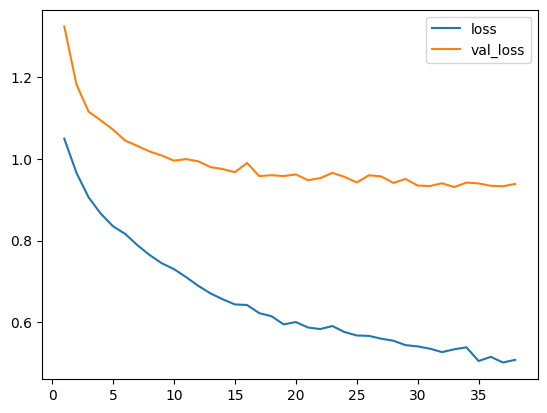

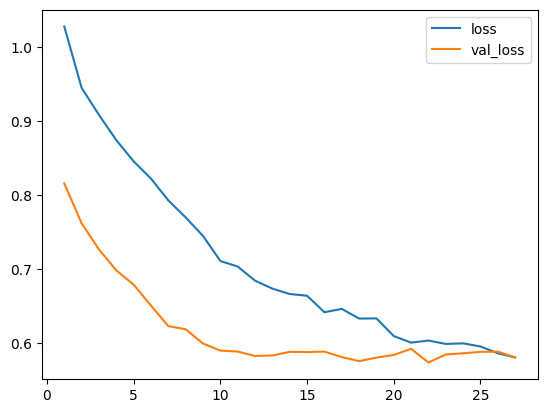

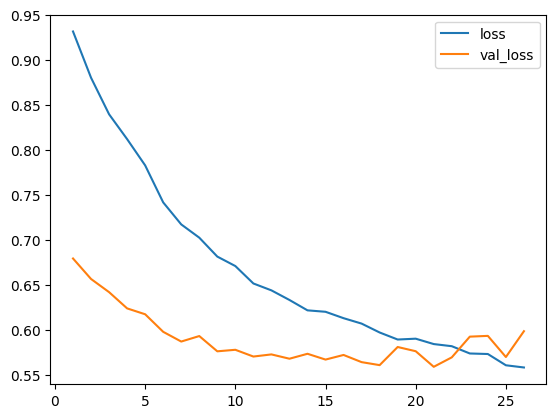

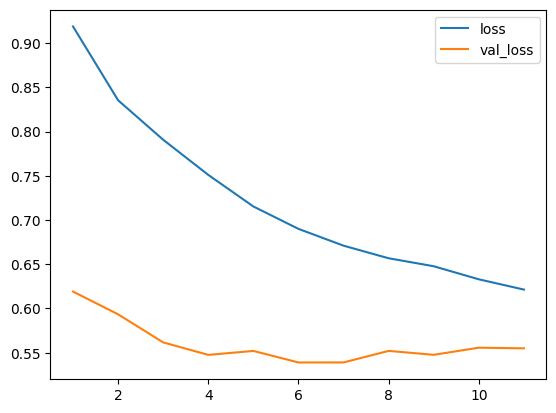

In [65]:
make_date_index(tbl_preds_CNN_DNN_optim)
tbl_preds_CNN_DNN_optim[(tbl_preds_CNN_DNN_optim["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_CNN_DNN_optim[tbl_history_CNN_DNN_optim["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Feature Selection - no optimization

In [162]:
init_params = {
    "neurons_CNN": 16,
    "neurons_dense_1": 16,
    "neurons_dense_2": 16,
    "neurons_dense_3": 16,
    "neurons_dense_4": 16,
    "activation_CNN": "relu",
    "activation_dense": "relu",
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_CNN_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(Conv1D(params["neurons_CNN"], kernel_size=1, activation=params["activation_CNN"]))
    model.add(Flatten())
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_1"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_2"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_3"], params["activation_dense"]))
    # model.add(Dropout(.2))
    model.add(Dense(params["neurons_dense_4"], params["activation_dense"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

CNN_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 125), 12, build_model_CNN_DNN, init_params)
CNN_DNNTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_CNN': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_CNN': 'relu', 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_CNN': 16, 'neurons_dense_1': 16, 'neurons_dense_2': 16, 'neurons_dense_3': 16, 'neurons_dense_4': 16, 'activation_CNN': 'relu', 'activation_dense': 'relu', 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 1, 16)             2016      
                                                                 
 flatten_18 (Flatten)        (None, 16)                0         
                                                                 
 dense_124 (Dense)           (None, 16)                272       
                                                       

In [163]:
model_CNN_DNN, tbl_preds_CNN_DNN, tbl_scores_CNN_DNN, tbl_history_CNN_DNN = CNN_DNNTimeSeriesForecaster.evaluate_model(batch_size=init_params["batch_size"], model_name="data_FE_FS_CNN_DNN_no_optim", save_destination="/Results/data_FE_FS_CNN_DNN_no_optim")

Iteration 1 out of 5
(1508, 1, 125) (1508, 12) (928, 1, 125) (928, 12) (408, 1, 125) (408, 12)
Epoch 1/1000
76/76 [==============================] - 1s 4ms/step - loss: 1.0352 - root_mean_squared_error: 1.0174 - mean_absolute_error: 0.7111 - val_loss: 0.9915 - val_root_mean_squared_error: 0.9958 - val_mean_absolute_error: 0.6865
Epoch 2/1000
76/76 [==============================] - 0s 2ms/step - loss: 1.0010 - root_mean_squared_error: 1.0005 - mean_absolute_error: 0.6916 - val_loss: 0.9525 - val_root_mean_squared_error: 0.9760 - val_mean_absolute_error: 0.6659
Epoch 3/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.9498 - root_mean_squared_error: 0.9746 - mean_absolute_error: 0.6614 - val_loss: 0.8826 - val_root_mean_squared_error: 0.9395 - val_mean_absolute_error: 0.6263
Epoch 4/1000
76/76 [==============================] - 0s 2ms/step - loss: 0.8887 - root_mean_squared_error: 0.9427 - mean_absolute_error: 0.6253 - val_loss: 0.8191 - val_root_mean_squared_error: 0.

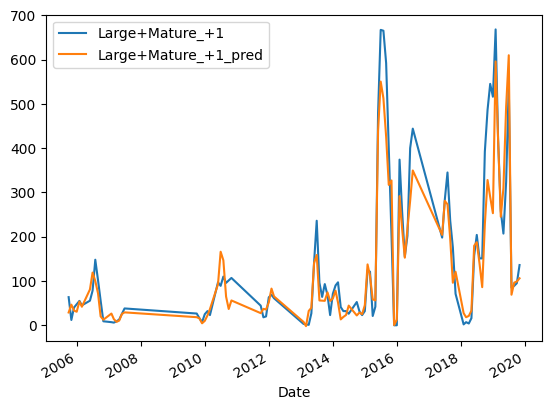

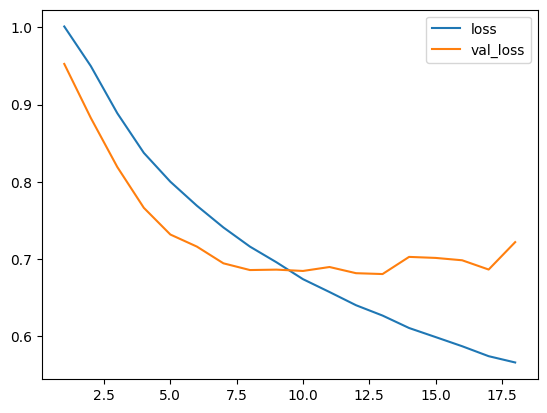

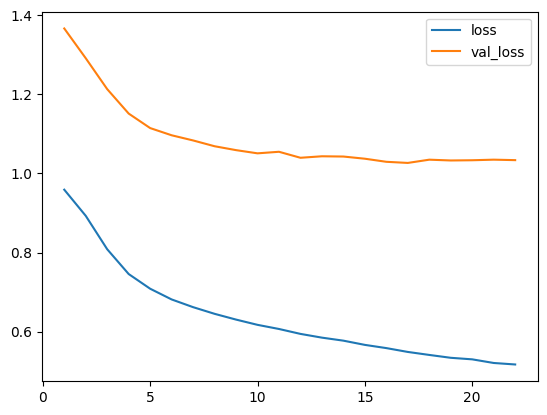

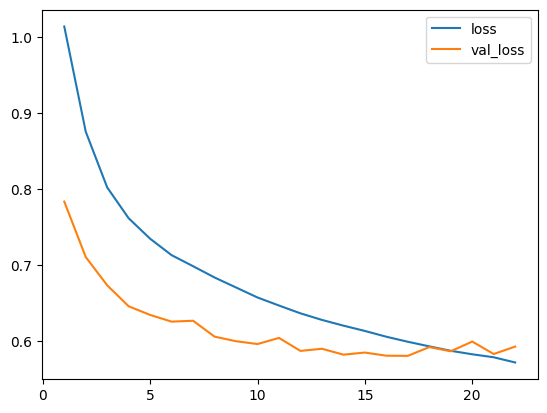

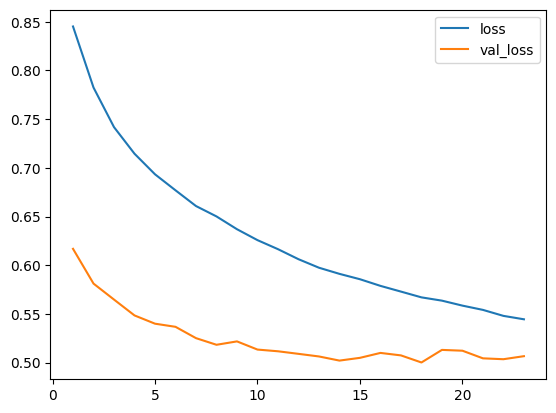

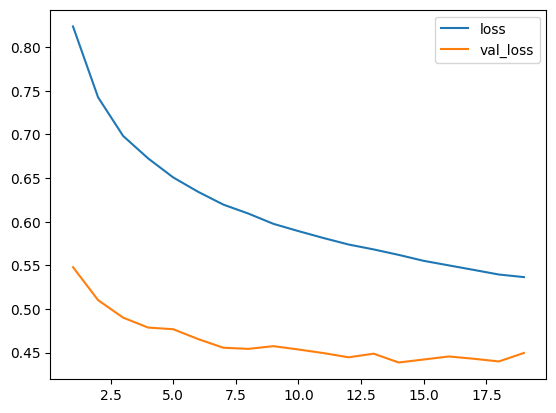

In [164]:
make_date_index(tbl_preds_CNN_DNN)
tbl_preds_CNN_DNN[(tbl_preds_CNN_DNN["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_CNN_DNN[tbl_history_CNN_DNN["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

#### Feature Selection - optimization

In [66]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10113837/
CNN_DNN_params = {
    "neurons_CNN": list(range(5, 100, 1)),
    "neurons_dense": list(range(5, 100, 1)),
    # "neurons_CNN": [16], # 94
    # "neurons_dense": [16], # 94
    # "activation": ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
    "activation": ["relu"],
    "learning_rate": [x/100000 for x in range(1, 101, 1)],
    # "learning_rate": [0.0005], # 0.00014
    # "optimizer": ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    "optimizer": ["Adam"],
    "batch_size": list(range(5, 50, 1)),
    "dropout": [x/100 for x in range(1, 100, 1)], # 0.05
    # "batch_size": [20] # 18
}

init_params = {
    "neurons_CNN": 16,
    "neurons_dense": 16,
    "activation": "relu",
    "dropout": 0.2,
    "learning_rate": 0.0005,
    "optimizer": 'Adam',
    "batch_size": 20
}

def build_model_CNN_DNN(input_dim, output_num, params):
    model = Sequential()
    model.add(InputLayer(input_dim))
    model.add(Conv1D(params["neurons_CNN"], kernel_size=1, activation=params["activation"]))
    model.add(Flatten())
    model.add(Dense(params["neurons_dense"], params["activation"]))
    model.add(Dense(params["neurons_dense"], params["activation"]))
    model.add(Dense(params["neurons_dense"], params["activation"]))
    model.add(Dense(params["neurons_dense"], params["activation"]))
    model.add(Dropout(params["dropout"]))
    model.add(Dense(output_num, 'linear'))

    model.compile(loss=MeanSquaredError(), optimizer=params["optimizer"], metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

CNN_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 125), 12, build_model_CNN_DNN, init_params)
CNN_DNNTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_CNN': 16, 'neurons_dense': 16, 'activation': 'relu', 'dropout': 0.2, 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
{'neurons_CNN': 16, 'neurons_dense': 16, 'activation': 'relu', 'dropout': 0.2, 'learning_rate': 0.0005, 'optimizer': 'Adam', 'batch_size': 20}
Model: "sequential_197"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_196 (Conv1D)         (None, 1, 16)             2016      
                                                                 
 flatten_196 (Flatten)       (None, 16)                0         
                                                                 
 dense_980 (Dense)           (None, 16)                272       
                                                                 
 dense_981 (Dense)           (None, 16)                272       
                                                                 
 dense_982 (Dense)           (

In [46]:
CNN_DNN_results = CNN_DNNTimeSeriesForecaster.optimize_model(build_model_CNN_DNN, CNN_DNN_params, input_dim = (1, 125), search_method = "random", num_samples=60)

Searching: 1/60
{'neurons_CNN': 15, 'neurons_dense': 55, 'activation': 'relu', 'learning_rate': 4e-05, 'optimizer': <keras.optimizers.adam.Adam object at 0x000001C8F46B38E0>, 'batch_size': 44, 'dropout': 0.11}
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_129 (Conv1D)         (None, 1, 15)             1890      
                                                                 
 flatten_129 (Flatten)       (None, 15)                0         
                                                                 
 dense_645 (Dense)           (None, 55)                880       
                                                                 
 dense_646 (Dense)           (None, 55)                3080      
                                                                 
 dense_647 (Dense)           (None, 55)                3080      
                                        

In [48]:
CNN_DNN_results[CNN_DNN_results["wmape_mean"] == CNN_DNN_results["wmape_mean"].min()]

neurons_CNN  neurons_dense activation  learning_rate  \
47           61             67       relu        0.00026   

                                            optimizer  batch_size  dropout  \
47  <keras.optimizers.adam.Adam object at 0x000001...          49      0.1   

    rmse_mean  rmse_std   mae_mean   mae_std  wmape_mean  wmape_std   r2_mean  \
47  30.667676  4.963612  19.472439  1.859674    0.527902   0.041977  0.333464   

      r2_std  
47  0.086584

In [77]:
CNN_DNN_results.to_csv("./Results/data_FE_FS_CNN_DNN_optim/opt_results_random.csv")

In [72]:
best_params = CNN_DNN_results[CNN_DNN_results["wmape_mean"] == CNN_DNN_results["wmape_mean"].min()]
best_params = best_params.drop(columns=["rmse_mean", "rmse_std", "mae_mean", "mae_std", "wmape_mean", "wmape_std", "r2_mean", "r2_std"])
best_params = best_params.to_dict(orient='records')[0]
best_params

{'neurons_CNN': 61,
 'neurons_dense': 67,
 'activation': 'relu',
 'learning_rate': 0.00026,
 'optimizer': <keras.optimizers.adam.Adam at 0x1c89df8da60>,
 'batch_size': 49,
 'dropout': 0.1}

In [73]:
best_params["optimizer"] = "Adam"
best_params["learning_rate"] = 0.0001

In [74]:
CNN_DNNTimeSeriesForecaster = TimeSeriesForecasters.DeepTimeSeriesForecaster((1, 125), 12, build_model_CNN_DNN, best_params)
CNN_DNNTimeSeriesForecaster.prepare_data(data_FE_FS, "FarmID", ["Tiny+Small", "Large+Mature"], 6)

{'neurons_CNN': 61, 'neurons_dense': 67, 'activation': 'relu', 'learning_rate': 0.0001, 'optimizer': 'Adam', 'batch_size': 49, 'dropout': 0.1}
{'neurons_CNN': 61, 'neurons_dense': 67, 'activation': 'relu', 'learning_rate': 0.0001, 'optimizer': 'Adam', 'batch_size': 49, 'dropout': 0.1}
Model: "sequential_199"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_198 (Conv1D)         (None, 1, 61)             7686      
                                                                 
 flatten_198 (Flatten)       (None, 61)                0         
                                                                 
 dense_990 (Dense)           (None, 67)                4154      
                                                                 
 dense_991 (Dense)           (None, 67)                4556      
                                                                 
 dense_992 (Dense)           (

In [75]:
model_CNN_DNN_optim, tbl_preds_CNN_DNN_optim, tbl_scores_CNN_DNN_optim, tbl_history_CNN_DNN_optim = CNN_DNNTimeSeriesForecaster.evaluate_model(batch_size=best_params["batch_size"], model_name="data_FE_FS_CNN_DNN_optim", save_destination="/Results/data_FE_FS_CNN_DNN_optim")

Iteration 1 out of 5
(1508, 1, 125) (1508, 12) (928, 1, 125) (928, 12) (408, 1, 125) (408, 12)
Epoch 1/1000
31/31 [==============================] - 1s 8ms/step - loss: 1.0271 - root_mean_squared_error: 1.0134 - mean_absolute_error: 0.7119 - val_loss: 0.9923 - val_root_mean_squared_error: 0.9961 - val_mean_absolute_error: 0.6927
Epoch 2/1000
31/31 [==============================] - 0s 4ms/step - loss: 1.0145 - root_mean_squared_error: 1.0072 - mean_absolute_error: 0.7071 - val_loss: 0.9781 - val_root_mean_squared_error: 0.9890 - val_mean_absolute_error: 0.6883
Epoch 3/1000
31/31 [==============================] - 0s 4ms/step - loss: 1.0002 - root_mean_squared_error: 1.0001 - mean_absolute_error: 0.7032 - val_loss: 0.9592 - val_root_mean_squared_error: 0.9794 - val_mean_absolute_error: 0.6839
Epoch 4/1000
31/31 [==============================] - 0s 4ms/step - loss: 0.9849 - root_mean_squared_error: 0.9924 - mean_absolute_error: 0.6990 - val_loss: 0.9357 - val_root_mean_squared_error: 0.

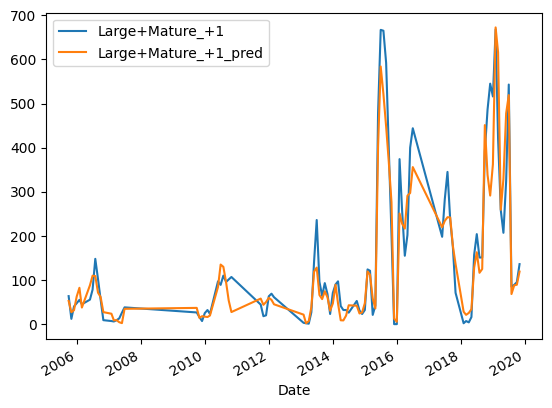

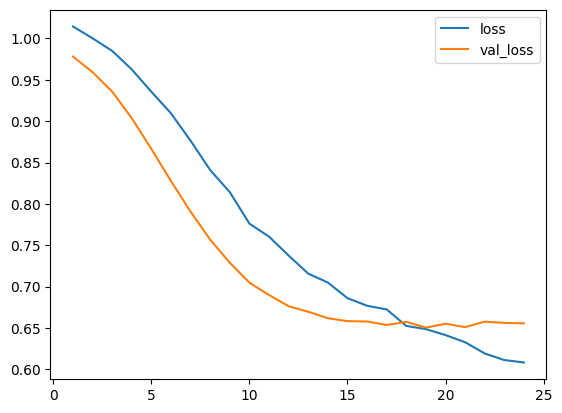

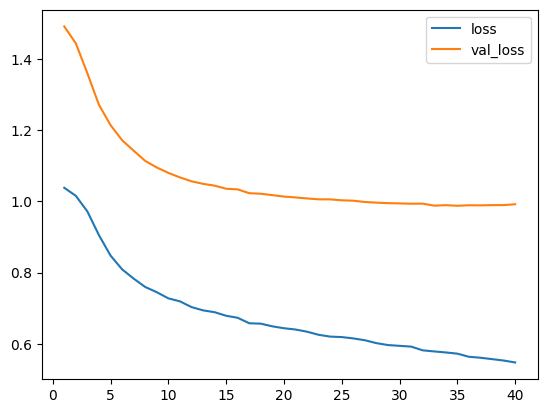

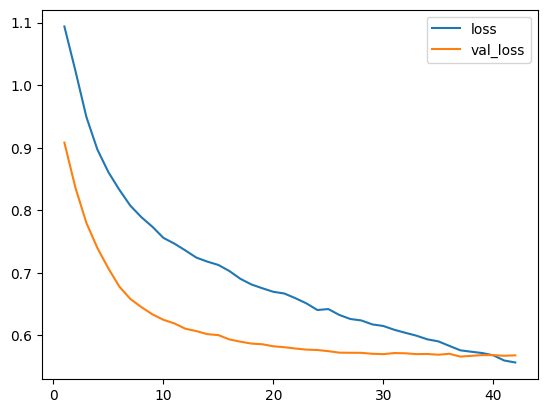

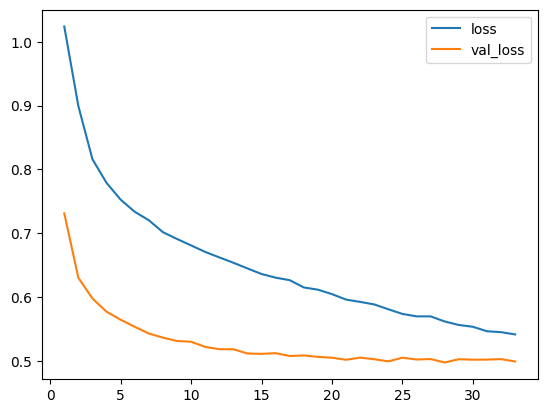

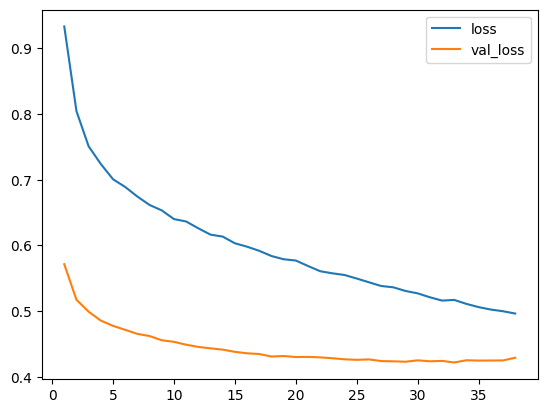

In [76]:
make_date_index(tbl_preds_CNN_DNN_optim)
tbl_preds_CNN_DNN_optim[(tbl_preds_CNN_DNN_optim["Iter_n"] == 1)].groupby("Date")[["Large+Mature_+1", "Large+Mature_+1_pred"]].sum().plot()
for i in range(1, 6):
    tbl_history_CNN_DNN_optim[tbl_history_CNN_DNN_optim["Iter_n"] == i][["loss", "val_loss"]].iloc[1:, :].plot()

## Auto-arima

In [12]:
stat_data = data[["FarmID", "year", "month", "Tiny+Small", "Large+Mature"]]
# stat_data = stat_data[stat_data["FarmID"].isin(['AG10', 'AG11', 'DA4', 'SP23', 'GA20'])]

In [13]:
stat_data

FarmID  year  month  Tiny+Small  Large+Mature
0      AG10  1998      1        43.0          13.0
1      AG10  1998      2        28.0          28.0
2      AG10  1998      3        13.0          43.0
3      AG10  1998      4        11.5          38.0
4      AG10  1998      5        10.0          33.0
...     ...   ...    ...         ...           ...
9011  MA413  2023      3         2.0          11.0
9012  MA413  2023      4         2.0           3.0
9013  MA413  2023      5         3.0           4.0
9014  MA413  2023      6         1.0           1.0
9015  MA413  2023      7         2.0           2.0

[9016 rows x 5 columns]

In [14]:
statTimeSeriesForecaster = TimeSeriesForecasters.StatTimeSeriesForecaster().prepare_data(stat_data, "FarmID", ["Tiny+Small", "Large+Mature"])

In [18]:
data_dict = {"train": pd.DataFrame(), "test": pd.DataFrame()}
for category in statTimeSeriesForecaster.data[statTimeSeriesForecaster.categorical_col_name].unique():
    train_data = statTimeSeriesForecaster.data[statTimeSeriesForecaster.data[statTimeSeriesForecaster.categorical_col_name] == category].iloc[:-6, :]
    test_data = statTimeSeriesForecaster.data[statTimeSeriesForecaster.data[statTimeSeriesForecaster.categorical_col_name] == category].tail(6)
    # Adding test data to the train data with leaving 6 rows for testing. This is specific to 
    # testing the statistics based model
    # train_data = train_data.append(test_data.iloc[:-6, :])
    # test_data = test_data.tail(6)

    data_dict["train"] = data_dict["train"].append(train_data, ignore_index=True)
    data_dict["test"] = data_dict["test"].append(test_data, ignore_index=True)

In [28]:
tbl_preds = pd.DataFrame()
train, test = data_dict["train"], data_dict["test"]
for j, farmid in enumerate(train[statTimeSeriesForecaster.categorical_col_name].unique()):
    print(f"Time series {j} out of {len(train[statTimeSeriesForecaster.categorical_col_name].unique())}")
    temp_train, temp_test = train[train[statTimeSeriesForecaster.categorical_col_name] == farmid], test[test[statTimeSeriesForecaster.categorical_col_name] == farmid]
    temp_train.drop(columns=[statTimeSeriesForecaster.categorical_col_name], inplace = True)
    temp_test.drop(columns=[statTimeSeriesForecaster.categorical_col_name], inplace = True)

    preds, real = statTimeSeriesForecaster.train_model(temp_train, temp_test, lag_period=12, is_seasonal=True)

    outcome = real
    outcome["Tiny+Small_pred"] = preds["Tiny+Small_pred"].values
    outcome["Large+Mature_pred"] = preds["Large+Mature_pred"].values
    outcome["FarmID"] = farmid
    tbl_preds = tbl_preds.append(outcome)

Time series 0 out of 68
Time series 1 out of 68
Time series 2 out of 68
Time series 3 out of 68
Time series 4 out of 68
Time series 5 out of 68
Time series 6 out of 68
Time series 7 out of 68
Time series 8 out of 68
Time series 9 out of 68
Time series 10 out of 68
Time series 11 out of 68
Time series 12 out of 68
Time series 13 out of 68
Time series 14 out of 68
Time series 15 out of 68
Time series 16 out of 68
Time series 17 out of 68
Time series 18 out of 68
Time series 19 out of 68
Time series 20 out of 68
Time series 21 out of 68
Time series 22 out of 68
Time series 23 out of 68
Time series 24 out of 68
Time series 25 out of 68
Time series 26 out of 68
Time series 27 out of 68
Time series 28 out of 68
Time series 29 out of 68
Time series 30 out of 68
Time series 31 out of 68
Time series 32 out of 68
Time series 33 out of 68
Time series 34 out of 68
Time series 35 out of 68
Time series 36 out of 68
Time series 37 out of 68
Time series 38 out of 68
Time series 39 out of 68
Time serie

In [31]:
preds = tbl_preds

<Axes: xlabel='Date'>

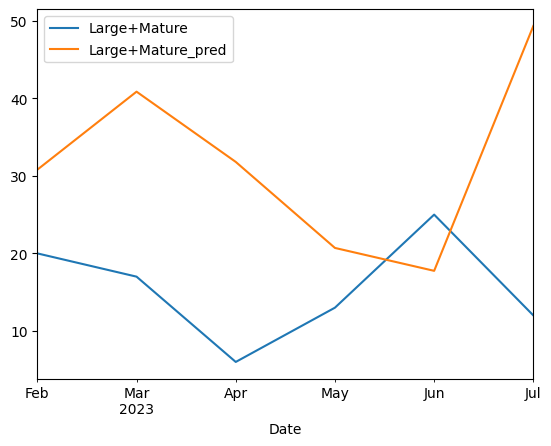

In [32]:
preds[preds["FarmID"] == "AG10"][["Large+Mature", "Large+Mature_pred"]].plot()

In [51]:
preds["Iter_n"] = 1

In [52]:
preds

Tiny+Small  Large+Mature  Tiny+Small_pred  Large+Mature_pred  \
Date                                                                       
2023-02-01        16.0          20.0        10.627329          30.797740   
2023-03-01         5.0          17.0        18.386412          40.856971   
2023-04-01        34.0           6.0        29.615379          31.798655   
2023-05-01        47.0          13.0        36.857293          20.703629   
2023-06-01        52.0          25.0        50.056936          17.749793   
...                ...           ...              ...                ...   
2023-03-01         2.0          11.0        12.052587          24.227369   
2023-04-01         2.0           3.0        12.052587          26.884483   
2023-05-01         3.0           4.0        12.052587          25.988330   
2023-06-01         1.0           1.0        12.052587          22.044141   
2023-07-01         2.0           2.0        12.052587          23.687201   

           FarmID  Iter_n  
Date                       
2023-02-01   AG10       1  
2023-03-01   AG10       1  
2023-04-01   AG10       1  
2023-05-01   AG10       1  
2023-06-01   AG10       1  
...           ...     ...  
2023-03-01  MA413       1  
2023-04-01  MA413       1  
2023-05-01  MA413       1  
2023-06-01  MA413       1  
2023-07-01  MA413       1  

[408 rows x 6 columns]

In [53]:
preds.to_csv("./Results/auto_arima/preds.csv")

In [37]:
def get_scores(tbl_preds):
    # Categorical variable related scores
    category_scores = {statTimeSeriesForecaster.categorical_col_name: [], "Target": [], "rmse": [], "wmape": [], "r2": [], "mae": []}

    for category in tbl_preds[statTimeSeriesForecaster.categorical_col_name].unique():
        for target in statTimeSeriesForecaster.targets:
            category_scores[statTimeSeriesForecaster.categorical_col_name].append(category)
            category_scores["Target"].append(target)
            category_scores["rmse"].append(sqrt(mse(tbl_preds[tbl_preds[statTimeSeriesForecaster.categorical_col_name] == category][target], 
            tbl_preds[tbl_preds[statTimeSeriesForecaster.categorical_col_name] == category][f"{target}_pred"])))
            category_scores["wmape"].append(wmape(tbl_preds[tbl_preds[statTimeSeriesForecaster.categorical_col_name] == category][target], 
            tbl_preds[tbl_preds[statTimeSeriesForecaster.categorical_col_name] == category][f"{target}_pred"]))
            category_scores["r2"].append(r2_score(tbl_preds[tbl_preds[statTimeSeriesForecaster.categorical_col_name] == category][target], 
            tbl_preds[tbl_preds[statTimeSeriesForecaster.categorical_col_name] == category][f"{target}_pred"]))
            category_scores["mae"].append(mae(tbl_preds[tbl_preds[statTimeSeriesForecaster.categorical_col_name] == category][target], 
            tbl_preds[tbl_preds[statTimeSeriesForecaster.categorical_col_name] == category][f"{target}_pred"]))

    tbl_preds_pivot = pd.DataFrame()
    target_values = statTimeSeriesForecaster.targets + [f"{target}_pred" for target in statTimeSeriesForecaster.targets]
    for category in tbl_preds[statTimeSeriesForecaster.categorical_col_name].unique():
        temp = tbl_preds[tbl_preds[statTimeSeriesForecaster.categorical_col_name] == category]
        temp = temp.reset_index()
        temp = temp.pivot(index=[statTimeSeriesForecaster.categorical_col_name], columns='Date', values=target_values)
        temp.columns = [f"{col[0]}_+{i}" for col, i in zip(temp.columns.values, list(range(1, 7)) * len(target_values))]
        temp = temp.reset_index()
        tbl_preds_pivot = tbl_preds_pivot.append(temp)

    targets_col = [f"{target}_+{i}" for target in statTimeSeriesForecaster.targets for i in list(range(1, 7))]
    preds_col = [f"{target}_+{i}" for target in [f"{target}_pred" for target in statTimeSeriesForecaster.targets] for i in list(range(1, 7))]
    target_scores = {"target": [], "rmse": [], "wmape": [], "r2": [], "mae": []}
    for target, pred in zip(targets_col, preds_col):
        target_scores["target"].append(target)
        target_scores["rmse"].append(sqrt(mse(tbl_preds_pivot[target], 
        tbl_preds_pivot[pred])))
        target_scores["wmape"].append(wmape(tbl_preds_pivot[target], 
        tbl_preds_pivot[pred]))
        target_scores["r2"].append(r2_score(tbl_preds_pivot[target], 
        tbl_preds_pivot[pred]))
        target_scores["mae"].append(mae(tbl_preds_pivot[target], 
        tbl_preds_pivot[pred]))

    return tbl_preds_pivot, pd.DataFrame(category_scores), pd.DataFrame(target_scores)

In [38]:
preds_pivot, farm_scores, target_scores = get_scores(preds)

In [41]:
target_scores

target       rmse     wmape        r2        mae
0     Tiny+Small_+1  16.743548  0.783014 -0.256393  12.522466
1     Tiny+Small_+2  16.766270  0.765939 -0.160007  13.077279
2     Tiny+Small_+3  22.523409  0.821939 -0.566252  16.861828
3     Tiny+Small_+4  28.326515  0.716377 -0.591777  19.963728
4     Tiny+Small_+5  31.565843  0.700929 -0.571821  21.656654
5     Tiny+Small_+6  26.052326  0.554015  0.158870  19.561604
6   Large+Mature_+1  13.426159  0.364026  0.713987  10.307831
7   Large+Mature_+2  19.684531  0.598381  0.357470  16.024280
8   Large+Mature_+3  21.235628  0.982014 -1.138335  17.098593
9   Large+Mature_+4  20.344190  1.066300 -2.044195  15.822003
10  Large+Mature_+5  22.310236  1.212147 -2.966546  18.324804
11  Large+Mature_+6  27.431954  0.992409 -1.835478  21.760035

In [227]:
preds_pivot

FarmID  Tiny+Small_+1  Tiny+Small_+2  Tiny+Small_+3  Tiny+Small_+4  \
0    AG10           16.0            5.0           34.0           47.0   
0    AG11            2.0            5.0           19.0           24.0   
0     DA4            0.0           13.0           28.0           25.0   
0    SP23            8.0            1.0           39.0           56.0   
0    GA20           13.0           15.0           21.0           15.0   
..    ...            ...            ...            ...            ...   
0   MA405            4.0           38.0           41.0           30.0   
0   MA401           13.0           16.0           17.0            9.0   
0   MA402            3.0           10.0           19.0           20.0   
0   MA412           46.0           35.0           36.0           48.0   
0   MA413            1.0            2.0            2.0            3.0   

    Tiny+Small_+5  Tiny+Small_+6  Large+Mature_+1  Large+Mature_+2  \
0            52.0           39.0             20.0             17.0   
0            34.0           67.0             17.0              9.0   
0            16.0           11.0              7.0              5.0   
0            68.0           58.0             17.0             15.0   
0            18.0           28.0             28.0             24.0   
..            ...            ...              ...              ...   
0            10.0            8.0             55.0             45.0   
0             4.0            5.0             10.0              5.0   
0            16.0           68.0             14.0             10.0   
0            17.0           35.0            108.0            103.0   
0             1.0            2.0             11.0             11.0   

    Large+Mature_+3  ...  Tiny+Small_pred_+3  Tiny+Small_pred_+4  \
0               6.0  ...           29.615379           36.857293   
0               9.0  ...           19.945635           26.744063   
0               8.0  ...            4.296462            2.208769   
0              11.0  ...           49.370694           81.621271   
0               9.0  ...           19.802564           20.316681   
..              ...  ...                 ...                 ...   
0              24.0  ...           45.000000           45.000000   
0              15.0  ...            6.000000            6.000000   
0               7.0  ...           11.515291           45.641541   
0              49.0  ...           42.280186           53.848995   
0               3.0  ...           12.052587           12.052587   

    Tiny+Small_pred_+5  Tiny+Small_pred_+6  Large+Mature_pred_+1  \
0            50.056936           58.529823             30.797740   
0            55.874463           86.492827             21.960740   
0            12.229694            4.505231              5.110635   
0            93.657003           79.218515             16.413340   
0            19.954691           19.403015             32.311238   
..                 ...                 ...                   ...   
0            45.000000           45.000000             57.124999   
0             6.000000            6.000000             23.960451   
0            21.468524           72.171862             11.449698   
0            64.383651           71.323167            102.322299   
0            12.052587           12.052587             15.436346   

    Large+Mature_pred_+2  Large+Mature_pred_+3  Large+Mature_pred_+4  \
0              40.856971             31.798655             20.703629   
0              36.695024             25.760664             14.834106   
0              10.971225             12.416953             11.857723   
0              20.280224             21.947862             22.599698   
0              28.581449             22.451902             17.493804   
..                   ...                   ...                   ...   
0              55.760577             48.630794             41.785457   
0              29.667966             36.145835             37.473935   
0  

In [48]:
farm_scores.to_csv("./Results/auto_arima/farm_scores.csv")
target_scores.to_csv("./Results/auto_arima/target_scores.csv")

In [42]:
preds_pivot_renamed = preds_pivot.rename(columns={"Tiny+Small_pred_+1": "Tiny+Small_+1_pred", "Tiny+Small_pred_+2": "Tiny+Small_+2_pred",
"Tiny+Small_pred_+3": "Tiny+Small_+3_pred", "Tiny+Small_pred_+4": "Tiny+Small_+4_pred", "Tiny+Small_pred_+5": "Tiny+Small_+5_pred",
"Tiny+Small_pred_+6": "Tiny+Small_+6_pred", "Large+Mature_pred_+1": "Large+Mature_+1_pred", "Large+Mature_pred_+2": "Large+Mature_+2_pred",
"Large+Mature_pred_+3": "Large+Mature_+3_pred", "Large+Mature_pred_+4": "Large+Mature_+4_pred", "Large+Mature_pred_+5": "Large+Mature_+5_pred",
"Large+Mature_pred_+6": "Large+Mature_+6_pred"})

In [49]:
preds_pivot_renamed.to_csv("./Results/auto_arima/preds_pivoted.csv")

In [44]:
scores = {"Model": [], "target": [], "rmse_mean": [], "rmse_std": [], "wmape_mean": [], "wmape_std": [], "mae_mean": [], "mae_std": [], "r2_mean": [], "r2_std": []}
for target in targets:
    scores["Model"].append("Auto-arima")
    scores["target"].append(target)
    score_temp = {"rmse": [], "wmape": [], "mae": [], "r2": []}
    grouped_df = preds_pivot_renamed[[target, f"{target}_pred"]]
    score_temp["rmse"].append(math.sqrt(mse(grouped_df[target], grouped_df[f"{target}_pred"])))
    score_temp["wmape"].append(wmape(grouped_df[target], grouped_df[f"{target}_pred"]))
    score_temp["mae"].append(mae(grouped_df[target], grouped_df[f"{target}_pred"]))
    score_temp["r2"].append(r2_score(grouped_df[target], grouped_df[f"{target}_pred"]))
        
    scores["rmse_mean"].append(np.mean(score_temp["rmse"]))
    scores["rmse_std"].append(np.std(score_temp["rmse"]))
    scores["wmape_mean"].append(np.mean(score_temp["wmape"]))
    scores["wmape_std"].append(np.std(score_temp["wmape"]))
    scores["mae_mean"].append(np.mean(score_temp["mae"]))
    scores["mae_std"].append(np.std(score_temp["mae"]))
    scores["r2_mean"].append(np.mean(score_temp["r2"]))
    scores["r2_std"].append(np.std(score_temp["r2"]))

In [46]:
pd.DataFrame(scores)

Model           target  rmse_mean  rmse_std  wmape_mean  wmape_std  \
0   Auto-arima    Tiny+Small_+1  16.743548       0.0    0.783014        0.0   
1   Auto-arima  Large+Mature_+1  13.426159       0.0    0.364026        0.0   
2   Auto-arima    Tiny+Small_+2  16.766270       0.0    0.765939        0.0   
3   Auto-arima  Large+Mature_+2  19.684531       0.0    0.598381        0.0   
4   Auto-arima    Tiny+Small_+3  22.523409       0.0    0.821939        0.0   
5   Auto-arima  Large+Mature_+3  21.235628       0.0    0.982014        0.0   
6   Auto-arima    Tiny+Small_+4  28.326515       0.0    0.716377        0.0   
7   Auto-arima  Large+Mature_+4  20.344190       0.0    1.066300        0.0   
8   Auto-arima    Tiny+Small_+5  31.565843       0.0    0.700929        0.0   
9   Auto-arima  Large+Mature_+5  22.310236       0.0    1.212147        0.0   
10  Auto-arima    Tiny+Small_+6  26.052326       0.0    0.554015        0.0   
11  Auto-arima  Large+Mature_+6  27.431954       0.0    0.992409        0.0   

     mae_mean  mae_std   r2_mean  r2_std  
0   12.522466      0.0 -0.256393     0.0  
1   10.307831      0.0  0.713987     0.0  
2   13.077279      0.0 -0.160007     0.0  
3   16.024280      0.0  0.357470     0.0  
4   16.861828      0.0 -0.566252     0.0  
5   17.098593      0.0 -1.138335     0.0  
6   19.963728      0.0 -0.591777     0.0  
7   15.822003      0.0 -2.044195     0.0  
8   21.656654      0.0 -0.571821     0.0  
9   18.324804      0.0 -2.966546     0.0  
10  19.561604      0.0  0.158870     0.0  
11  21.760035      0.0 -1.835478     0.0

In [50]:
pd.DataFrame(scores).to_csv("./Results/auto_arima/global_scores.csv")